# Libraries

In [222]:
# Libraries

import pandas as pd
import numpy as np
import glob
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import os
import praw                     # Reddit API
import nltk                     # Sentimental Analysis
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from scipy import stats
from scipy.stats import poisson
from scipy.stats import norm
import math
import random
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
# hide warnings
import warnings
warnings.filterwarnings('ignore')
sns.set_theme();

# Datasets

## - Dataset - Price indices for means of production of agricultural INPUTS

In [2]:
input_agri = pd.read_csv("Price indices of the means of agricultural input production.csv");input_agri

,freq,p_adj,unit,product,geo_TIME_PERIOD,2000-Q1,2000-Q2,2000-Q3,2000-Q4,2001-Q1,...,2015-Q3,2015-Q4,2016-Q1,2016-Q2,2016-Q3,2016-Q4,2017-Q1,2017-Q2,2017-Q3,2017-Q4
0,Q,NI,I10,200000,AT,:,:,:,:,:,...,113.1,111.7,111.1,112.7,112.3,111.8,113.8,114.6,113.2,113.3
1,Q,NI,I10,200000,BE,:,:,:,:,83.3,...,107.7,107,104.7,105.9,107.1,107.7,111.1,109.7,108.8,109.8
2,Q,NI,I10,200000,BG,:,:,:,:,:,...,108.1,105.6,102.9,101.8,100.8,102.2,104.2,103.8,102,104.1
3,Q,NI,I10,200000,CY,:,:,:,:,:,...,118.4,107,108,109.9,113.3,108,113,115,110,107
4,Q,NI,I10,200000,CZ,83.7,85.1,87.7,91.1,89.4,...,111,109.4,107.9,107.3,105.9,106.2,108.4,108.6,107.8,108.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5419,Q,RI,PCH_SM,220000,RO,:,:,:,:,:,...,-5.1,-3.4,-2.3,-2.6,-4.2,-1.3,1.8,0.4,3.2,1.9
5420,Q,RI,PCH_SM,220000,SE,:,:,:,:,:,...,-1,-0.8,-2,-3.1,-2.6,-1.7,0,0.7,0.9,1.2
5421,Q,RI,PCH_SM,220000,SI,:,:,:,:,5.8,...,-2.3,-1.2,-1.1,-2.1,-1.5,-2.2,-0.8,-1.1,-1.2,0.7
5422,Q,RI,PCH_SM,220000,SK,:,:,:,:,8.5,...,-5.8,-3.4,-3.4,-3.9,-4.2,-5.1,-2,-2.1,-0.4,1.4


In [3]:
input_agri.shape

(5424, 77)

## - Dataset - Price indices of agricultural OUTPUT products

### Importing the dataset in the database

- The process to import the dataset and create a database was made directly in MYSQL Workbench software, following the steps above:
    1) The MySQL Workbench software was opened;
    2) The connection to the MySQL database was made;
    3) A schema called 'agriculture' was created;
    4) By pressing the right mouse button on the "agriculture" schema, the Table Data Import Wizard option was selected to import the dataset;
    5) The directory where the dataset was saved was selected;
    6) The 'Create a new table' option was selected and a name was defined for the table;
    7) On the next screen, the format of each of the dataset variables and the encoding used were selected;
    8) Finally, the process of importing the dataset into the 'agriculture' schema in the database was carried out.

### Setting up the Environment Variables

In [4]:
db_host = os.getenv('DB_HOST')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_name = os.getenv('DB_NAME')

### Creating a MySQL Connection and Opening the Database

In [5]:
connection = mysql.connector.connect(
    host = db_host,
    user = db_user,
    password = db_password,
    database = db_name
)

- Checking the connection with MySQL

In [6]:
if connection.is_connected():
    print('Connection successful')
else:
    print('Not connected')

Connection successful


- Opening the SQL file

In [7]:
with open('agriculture_database.sql', 'r') as arquivo:
    script_sql = arquivo.read()

In [8]:
cursor = connection.cursor()

### Executing Queries in the Database and Transforming the Data

In [9]:
for statement in script_sql.split(';'):
    if statement.strip():
        cursor.execute(statement)

In [10]:
connection.commit()

In [11]:
query_output = '''
SELECT 
	T1.product,
    T2.subclass,
	T1.geo_TIME_PERIOD,
	`2000-Q1`,
	`2000-Q2`,
	`2000-Q3`,
	`2000-Q4`,
	`2001-Q1`,
	`2001-Q2`,
	`2001-Q3`,
	`2001-Q4`,
	`2002-Q1`,
	`2002-Q2`,
	`2002-Q3`,
	`2002-Q4`,
	`2003-Q1`,
	`2003-Q2`,
	`2003-Q3`,
	`2003-Q4`,
	`2004-Q1`,
	`2004-Q2`,
	`2004-Q3`,
	`2004-Q4`,
	`2005-Q1`,
	`2005-Q2`,
	`2005-Q3`,
	`2005-Q4`,
	`2006-Q1`,
	`2006-Q2`,
	`2006-Q3`,
	`2006-Q4`,
	`2007-Q1`,
	`2007-Q2`,
	`2007-Q3`,
	`2007-Q4`,
	`2008-Q1`,
	`2008-Q2`,
	`2008-Q3`,
	`2008-Q4`,
	`2009-Q1`,
	`2009-Q2`,
	`2009-Q3`,
	`2009-Q4`,
	`2010-Q1`,
	`2010-Q2`,
	`2010-Q3`,
	`2010-Q4`,
	`2011-Q1`,
	`2011-Q2`,
	`2011-Q3`,
	`2011-Q4`,
	`2012-Q1`,
	`2012-Q2`,
	`2012-Q3`,
	`2012-Q4`,
	`2013-Q1`,
	`2013-Q2`,
	`2013-Q3`,
	`2013-Q4`,
	`2014-Q1`,
	`2014-Q2`,
	`2014-Q3`,
	`2014-Q4`,
	`2015-Q1`,
	`2015-Q2`,
	`2015-Q3`,
	`2015-Q4`,
	`2016-Q1`,
	`2016-Q2`,
	`2016-Q3`,
	`2016-Q4`,
	`2017-Q1`,
	`2017-Q2`,
	`2017-Q3`,
	`2017-Q4`
FROM agriculture.price_indices_agricultural_output_products AS T1
LEFT JOIN agriculture.tabproductsinputsoutputs_api AS T2
ON T1.product = T2.Item;
'''

In [12]:
# Execute the query
cursor.execute(query_output)

In [13]:
# Process the results
results = cursor.fetchall()

In [14]:
output_agri = pd.read_sql(query_output,connection)
output_agri

,product,subclass,geo_TIME_PERIOD,2000-Q1,2000-Q2,2000-Q3,2000-Q4,2001-Q1,2001-Q2,2001-Q3,...,2015-Q3,2015-Q4,2016-Q1,2016-Q2,2016-Q3,2016-Q4,2017-Q1,2017-Q2,2017-Q3,2017-Q4
0,010000,CEREALS,AT,:,:,:,:,:,:,:,...,75.8,82.1,82.6,83.5,62.6,69.5,79.2,81.7,77.6,79.8
1,010000,CEREALS,BE,:,:,:,:,67.2,68.4,67.9,...,93.1,97.7,86.7,79,69.5,92.5,92.1,90.1,88.3,89.1
2,010000,CEREALS,BG,:,:,:,:,:,:,:,...,123.1,108.8,115.9,117.5,108.9,105.9,122.2,119.6,112.6,102.3
3,010000,CEREALS,CY,:,:,:,:,:,:,:,...,190,:,:,170.3,216.8,:,:,167.3,178.4,:
4,010000,CEREALS,CZ,91.1,96,102.7,113.5,120.4,126.5,117.1,...,129.4,131.2,128.2,118.3,113.5,113.2,116,121.4,120.7,121.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,141000,TOTAL AGRICULTURAL GOODS,RO,:,:,:,:,38.6,29.9,5.6,...,0.6,5,4.8,2.3,-4.9,-3,-1.8,0.4,-1.5,-0.4
6428,141000,TOTAL AGRICULTURAL GOODS,SE,:,:,:,:,:,:,:,...,-1,0.9,0.3,-0.4,0.5,2.8,5.5,4.3,5.9,5.9
6429,141000,TOTAL AGRICULTURAL GOODS,SI,:,:,:,:,-5.5,0.2,-2.8,...,-5,-0.8,-2,-5.6,-5.7,-1,-0.5,6.5,9.1,5.4
6430,141000,TOTAL AGRICULTURAL GOODS,SK,:,:,:,:,2.9,2.6,-1.1,...,-0.8,4.8,0.5,-2.7,-5.6,-10.9,-6.1,1.1,5.8,10.2


In [15]:
query_tab_codes = 'SELECT * FROM agriculture.tabproductsinputsoutputs_api; '

In [16]:
# Execute the query
cursor.execute(query_tab_codes)

In [17]:
# Process the results
results = cursor.fetchall()

In [18]:
tab_code_products = pd.read_sql(query_tab_codes,connection)
tab_code_products

,Item,class,subclass,Description
0,010000,CEREALS,CEREALS,CEREALS (including seeds)
1,011000,CEREALS,CEREALS,Wheat and spelt
2,011100,CEREALS,CEREALS,Soft wheat and spelt
3,011200,CEREALS,CEREALS,Durum wheat
4,012000,CEREALS,CEREALS,Rye and Meslin
...,...,...,...,...
168,212000,GOODS AND SERVICES CONTRIBUTING TO AGRICULTURA...,BUILDINGS,BUILDINGS
169,212100,GOODS AND SERVICES CONTRIBUTING TO AGRICULTURA...,FARM BUILDINGS (NON-RESIDENTIAL),FARM BUILDINGS (NON-RESIDENTIAL)
170,212900,GOODS AND SERVICES CONTRIBUTING TO AGRICULTURA...,OTHER WORKS EXCEPT LAND IMPROVEMENTS (OTHER BU...,OTHER WORKS EXCEPT LAND IMPROVEMENTS (OTHER BU...
171,219000,GOODS AND SERVICES CONTRIBUTING TO AGRICULTURA...,OTHER,OTHER


- Close the cursor and the connection

In [19]:
cursor.close()
connection.close()

- Checking the connection with MySQL

In [20]:
if connection.is_connected():
    print('Connection successful')
else:
    print('Not connected')

Not connected


- Checking the shape of the dataframes 'output_agri' and 'tab_code_products'

In [21]:
output_agri.shape

(6432, 75)

In [22]:
tab_code_products.shape

(173, 4)

## - Dataset - Table of Country Codes - ALPHA-2 & ALPHA-3 

- Reading the table from the website page IBAN.com

In [23]:
url = 'https://www.iban.com/country-codes'

In [24]:
iban = pd.read_html(url)

In [25]:
country_codes = iban[0]
country_codes

,Country,Alpha-2 code,Alpha-3 code,Numeric
0,Afghanistan,AF,AFG,4
1,Åland Islands,AX,ALA,248
2,Albania,AL,ALB,8
3,Algeria,DZ,DZA,12
4,American Samoa,AS,ASM,16
...,...,...,...,...
244,Wallis and Futuna,WF,WLF,876
245,Western Sahara,EH,ESH,732
246,Yemen,YE,YEM,887
247,Zambia,ZM,ZMB,894


- Adding a Line to United Kingdom

In [26]:
uk = {'Country': 'United Kingdom','Alpha-2 code': 'UK', 'Alpha-3 code':'UK', 'Numeric':0 }
country_codes.loc[len(country_codes)] = uk
country_codes

,Country,Alpha-2 code,Alpha-3 code,Numeric
0,Afghanistan,AF,AFG,4
1,Åland Islands,AX,ALA,248
2,Albania,AL,ALB,8
3,Algeria,DZ,DZA,12
4,American Samoa,AS,ASM,16
...,...,...,...,...
245,Western Sahara,EH,ESH,732
246,Yemen,YE,YEM,887
247,Zambia,ZM,ZMB,894
248,Zimbabwe,ZW,ZWE,716


# Data Preparation

## - Data Preparation - Price indices for means of production of agricultural INPUTS

In [27]:
input_agri.head()

,freq,p_adj,unit,product,geo_TIME_PERIOD,2000-Q1,2000-Q2,2000-Q3,2000-Q4,2001-Q1,...,2015-Q3,2015-Q4,2016-Q1,2016-Q2,2016-Q3,2016-Q4,2017-Q1,2017-Q2,2017-Q3,2017-Q4
0,Q,NI,I10,200000,AT,:,:,:,:,:,...,113.1,111.7,111.1,112.7,112.3,111.8,113.8,114.6,113.2,113.3
1,Q,NI,I10,200000,BE,:,:,:,:,83.3,...,107.7,107,104.7,105.9,107.1,107.7,111.1,109.7,108.8,109.8
2,Q,NI,I10,200000,BG,:,:,:,:,:,...,108.1,105.6,102.9,101.8,100.8,102.2,104.2,103.8,102,104.1
3,Q,NI,I10,200000,CY,:,:,:,:,:,...,118.4,107,108,109.9,113.3,108,113,115,110,107
4,Q,NI,I10,200000,CZ,83.7,85.1,87.7,91.1,89.4,...,111,109.4,107.9,107.3,105.9,106.2,108.4,108.6,107.8,108.7


- Removing Columns

In [28]:
input_agri.drop(columns = ['freq','p_adj','unit'],inplace = True)

- Transforming variable product in objects

In [29]:
input_agri['product'] = input_agri['product'].astype('object')

In [30]:
input_agri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5424 entries, 0 to 5423
Data columns (total 74 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   product          5424 non-null   object
 1   geo_TIME_PERIOD  5424 non-null   object
 2   2000-Q1          5424 non-null   object
 3   2000-Q2          5424 non-null   object
 4   2000-Q3          5424 non-null   object
 5   2000-Q4          5424 non-null   object
 6   2001-Q1          5424 non-null   object
 7   2001-Q2          5424 non-null   object
 8   2001-Q3          5424 non-null   object
 9   2001-Q4          5424 non-null   object
 10  2002-Q1          5424 non-null   object
 11  2002-Q2          5424 non-null   object
 12  2002-Q3          5424 non-null   object
 13  2002-Q4          5424 non-null   object
 14  2003-Q1          5424 non-null   object
 15  2003-Q2          5424 non-null   object
 16  2003-Q3          5424 non-null   object
 17  2003-Q4          5424 non-null   

- Transforming columns into rows

In [31]:
input_agri_transp = input_agri.melt(id_vars = ['product','geo_TIME_PERIOD'], var_name = 'date', value_name = 'value')

- Creating the variable "Class" for Inputs

In [32]:
input_agri_transp['type'] = 'inputs'

In [33]:
input_agri_transp.head()

,product,geo_TIME_PERIOD,date,value,type
0,200000,AT,2000-Q1,:,inputs
1,200000,BE,2000-Q1,:,inputs
2,200000,BG,2000-Q1,:,inputs
3,200000,CY,2000-Q1,:,inputs
4,200000,CZ,2000-Q1,83.7,inputs


- Merging the datasets 'input_agri_transp' and 'tab_code_products' 

In [34]:
## Merging the datasets
input_agri_f = pd.merge(input_agri_transp,tab_code_products, left_on=[input_agri_transp['product'].astype('int64')], right_on = [tab_code_products['Item'].astype('int64')], how = 'left')
input_agri_f

,key_0,product,geo_TIME_PERIOD,date,value,type,Item,class,subclass,Description
0,200000,200000,AT,2000-Q1,:,inputs,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
1,200000,200000,BE,2000-Q1,:,inputs,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
2,200000,200000,BG,2000-Q1,:,inputs,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
3,200000,200000,CY,2000-Q1,:,inputs,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
4,200000,200000,CZ,2000-Q1,83.7,inputs,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
...,...,...,...,...,...,...,...,...,...,...
390523,220000,220000,RO,2017-Q4,1.9,inputs,220000,INPUT TOTAL,INPUT TOTAL,INPUT TOTAL (INPUT 1 + INPUT 2)
390524,220000,220000,SE,2017-Q4,1.2,inputs,220000,INPUT TOTAL,INPUT TOTAL,INPUT TOTAL (INPUT 1 + INPUT 2)
390525,220000,220000,SI,2017-Q4,0.7,inputs,220000,INPUT TOTAL,INPUT TOTAL,INPUT TOTAL (INPUT 1 + INPUT 2)
390526,220000,220000,SK,2017-Q4,1.4,inputs,220000,INPUT TOTAL,INPUT TOTAL,INPUT TOTAL (INPUT 1 + INPUT 2)


- Removing Columns 'key_0', 'class_y' and 'Description'

In [35]:
input_agri_f.drop(columns = ['key_0','class','Item','Description'],inplace = True)

In [36]:
input_agri_f

,product,geo_TIME_PERIOD,date,value,type,subclass
0,200000,AT,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
1,200000,BE,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
2,200000,BG,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
3,200000,CY,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
4,200000,CZ,2000-Q1,83.7,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
...,...,...,...,...,...,...
390523,220000,RO,2017-Q4,1.9,inputs,INPUT TOTAL
390524,220000,SE,2017-Q4,1.2,inputs,INPUT TOTAL
390525,220000,SI,2017-Q4,0.7,inputs,INPUT TOTAL
390526,220000,SK,2017-Q4,1.4,inputs,INPUT TOTAL


## - Data Preparation - Price indices of agricultural OUTPUT products

In [37]:
output_agri.head()

,product,subclass,geo_TIME_PERIOD,2000-Q1,2000-Q2,2000-Q3,2000-Q4,2001-Q1,2001-Q2,2001-Q3,...,2015-Q3,2015-Q4,2016-Q1,2016-Q2,2016-Q3,2016-Q4,2017-Q1,2017-Q2,2017-Q3,2017-Q4
0,010000,CEREALS,AT,:,:,:,:,:,:,:,...,75.8,82.1,82.6,83.5,62.6,69.5,79.2,81.7,77.6,79.8
1,010000,CEREALS,BE,:,:,:,:,67.2,68.4,67.9,...,93.1,97.7,86.7,79,69.5,92.5,92.1,90.1,88.3,89.1
2,010000,CEREALS,BG,:,:,:,:,:,:,:,...,123.1,108.8,115.9,117.5,108.9,105.9,122.2,119.6,112.6,102.3
3,010000,CEREALS,CY,:,:,:,:,:,:,:,...,190,:,:,170.3,216.8,:,:,167.3,178.4,:
4,010000,CEREALS,CZ,91.1,96,102.7,113.5,120.4,126.5,117.1,...,129.4,131.2,128.2,118.3,113.5,113.2,116,121.4,120.7,121.9


- Transforming columns into rows

In [38]:
output_agri_transp = output_agri.melt(id_vars = ['product','subclass','geo_TIME_PERIOD'], var_name = 'date', value_name = 'value')

- Creating the variable "Class" for Inputs

In [39]:
output_agri_transp['type'] = 'outputs'

In [40]:
output_agri_transp

,product,subclass,geo_TIME_PERIOD,date,value,type
0,010000,CEREALS,AT,2000-Q1,:,outputs
1,010000,CEREALS,BE,2000-Q1,:,outputs
2,010000,CEREALS,BG,2000-Q1,:,outputs
3,010000,CEREALS,CY,2000-Q1,:,outputs
4,010000,CEREALS,CZ,2000-Q1,91.1,outputs
...,...,...,...,...,...,...
463099,141000,TOTAL AGRICULTURAL GOODS,RO,2017-Q4,-0.4,outputs
463100,141000,TOTAL AGRICULTURAL GOODS,SE,2017-Q4,5.9,outputs
463101,141000,TOTAL AGRICULTURAL GOODS,SI,2017-Q4,5.4,outputs
463102,141000,TOTAL AGRICULTURAL GOODS,SK,2017-Q4,10.2,outputs


## - Merging the Datasets

### Merging the Datasets of Agricultural Inputs and Outputs products

In [41]:
input_output = pd.concat([input_agri_f,output_agri_transp])
input_output

,product,geo_TIME_PERIOD,date,value,type,subclass
0,200000,AT,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
1,200000,BE,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
2,200000,BG,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
3,200000,CY,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
4,200000,CZ,2000-Q1,83.7,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...
...,...,...,...,...,...,...
463099,141000,RO,2017-Q4,-0.4,outputs,TOTAL AGRICULTURAL GOODS
463100,141000,SE,2017-Q4,5.9,outputs,TOTAL AGRICULTURAL GOODS
463101,141000,SI,2017-Q4,5.4,outputs,TOTAL AGRICULTURAL GOODS
463102,141000,SK,2017-Q4,10.2,outputs,TOTAL AGRICULTURAL GOODS


### Mergind the Dataset of Table Country Codes

In [42]:
## Merging the datasets
input_output = pd.merge(input_output,country_codes, left_on=[input_output['geo_TIME_PERIOD']], right_on = [country_codes['Alpha-2 code']], how = 'left')
input_output

,key_0,product,geo_TIME_PERIOD,date,value,type,subclass,Country,Alpha-2 code,Alpha-3 code,Numeric
0,AT,200000,AT,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Austria,AT,AUT,40.0
1,BE,200000,BE,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Belgium,BE,BEL,56.0
2,BG,200000,BG,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Bulgaria,BG,BGR,100.0
3,CY,200000,CY,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Cyprus,CY,CYP,196.0
4,CZ,200000,CZ,2000-Q1,83.7,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Czechia,CZ,CZE,203.0
...,...,...,...,...,...,...,...,...,...,...,...
853627,RO,141000,RO,2017-Q4,-0.4,outputs,TOTAL AGRICULTURAL GOODS,Romania,RO,ROU,642.0
853628,SE,141000,SE,2017-Q4,5.9,outputs,TOTAL AGRICULTURAL GOODS,Sweden,SE,SWE,752.0
853629,SI,141000,SI,2017-Q4,5.4,outputs,TOTAL AGRICULTURAL GOODS,Slovenia,SI,SVN,705.0
853630,SK,141000,SK,2017-Q4,10.2,outputs,TOTAL AGRICULTURAL GOODS,Slovakia,SK,SVK,703.0


## - Transforming Columns

- Separating the column "Date" in "Year" and "Quarter"

In [43]:
input_output[['year','quarter']] = input_output['date'].str.split('-Q',expand = True)
input_output.head()

,key_0,product,geo_TIME_PERIOD,date,value,type,subclass,Country,Alpha-2 code,Alpha-3 code,Numeric,year,quarter
0,AT,200000,AT,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Austria,AT,AUT,40.0,2000,1
1,BE,200000,BE,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Belgium,BE,BEL,56.0,2000,1
2,BG,200000,BG,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Bulgaria,BG,BGR,100.0,2000,1
3,CY,200000,CY,2000-Q1,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Cyprus,CY,CYP,196.0,2000,1
4,CZ,200000,CZ,2000-Q1,83.7,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Czechia,CZ,CZE,203.0,2000,1


- Removing Columns

In [44]:
input_output.drop(columns = ['date','key_0','Alpha-2 code','Numeric'], inplace = True)

In [45]:
input_output

,product,geo_TIME_PERIOD,value,type,subclass,Country,Alpha-3 code,year,quarter
0,200000,AT,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Austria,AUT,2000,1
1,200000,BE,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Belgium,BEL,2000,1
2,200000,BG,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Bulgaria,BGR,2000,1
3,200000,CY,:,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Cyprus,CYP,2000,1
4,200000,CZ,83.7,inputs,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,Czechia,CZE,2000,1
...,...,...,...,...,...,...,...,...,...
853627,141000,RO,-0.4,outputs,TOTAL AGRICULTURAL GOODS,Romania,ROU,2017,4
853628,141000,SE,5.9,outputs,TOTAL AGRICULTURAL GOODS,Sweden,SWE,2017,4
853629,141000,SI,5.4,outputs,TOTAL AGRICULTURAL GOODS,Slovenia,SVN,2017,4
853630,141000,SK,10.2,outputs,TOTAL AGRICULTURAL GOODS,Slovakia,SVK,2017,4


- Renaming and reordering the collums

In [46]:
input_output = input_output.rename(columns = {'geo_TIME_PERIOD':'country_code', 'Alpha-3 code': 'country_code_a3','subclass':'class'})
input_output = input_output[['type','country_code','country_code_a3','Country','year','quarter','product','class','value']]
input_output.columns.name = None
input_output

,type,country_code,country_code_a3,Country,year,quarter,product,class,value
0,inputs,AT,AUT,Austria,2000,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,:
1,inputs,BE,BEL,Belgium,2000,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,:
2,inputs,BG,BGR,Bulgaria,2000,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,:
3,inputs,CY,CYP,Cyprus,2000,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,:
4,inputs,CZ,CZE,Czechia,2000,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,83.7
...,...,...,...,...,...,...,...,...,...
853627,outputs,RO,ROU,Romania,2017,4,141000,TOTAL AGRICULTURAL GOODS,-0.4
853628,outputs,SE,SWE,Sweden,2017,4,141000,TOTAL AGRICULTURAL GOODS,5.9
853629,outputs,SI,SVN,Slovenia,2017,4,141000,TOTAL AGRICULTURAL GOODS,5.4
853630,outputs,SK,SVK,Slovakia,2017,4,141000,TOTAL AGRICULTURAL GOODS,10.2


- Removing Classes that Indicate Totalizers

In [47]:
input_output['class'].unique()

array(['GOODS AND SERVICES CURRENTLY CONSUMED IN AGRICULTURE (INPUT 1)',
       'SEEDS AND PLANTING STOCK', 'ENERGY',
       'FERTILISERS AND SOIL IMPROVERS',
       'PLANT PROTECTION PRODUCTS AND PESTICIDES', 'VETERINARY EXPENSES',
       'ANIMAL FEEDINGSTUFFS', 'MAINTENANCE OF MATERIALS',
       'MAINTENANCE OF BUILDINGS', 'OTHER GOODS AND SERVICES',
       'GOODS AND SERVICES CONTRIBUTING TO AGRICULTURAL INVESTMENT (INPUT 2)',
       'MATERIALS', 'MACHINERY AND OTHER EQUIPMENT',
       'TRANSPORT EQUIPMENT', 'BUILDINGS',
       'FARM BUILDINGS (NON-RESIDENTIAL)',
       'OTHER WORKS EXCEPT LAND IMPROVEMENTS (OTHER BUILDINGS, STRUCTURES, ETC.)',
       'OTHER', 'INPUT TOTAL', 'CEREALS', 'INDUSTRIAL CROPS',
       'FORAGE PLANTS', 'VEGETABLES AND HORTICULTURAL PRODUCTS',
       'POTATOES', 'FRUIT', 'WINE', 'OLIVE OIL', 'OTHER CROP PRODUCTS',
       'TOTAL CROP', 'ANIMALS', 'ANIMAL PRODUCTS', 'TOTAL ANIMAL',
       'TOTAL AGRICULTURAL GOODS'], dtype=object)

In [48]:
input_output = input_output[~input_output['class'].isin(['TOTAL CROP','TOTAL ANIMAL','TOTAL AGRICULTURAL GOODS','INPUT TOTAL'])]

- Removing Country Code UK

In [49]:
input_output = input_output[~input_output['country_code'].isin(['UK'])]

## - Missing Values

### Formating the variable 'values' to indentify Missing Values

- Changing values ": " to NULL in the variable 'value'

In [50]:
input_output['value'] = input_output['value'].replace(': ','')
input_output['value'] = input_output['value'].replace(r'[^\d.-]','', regex = True)
input_output

,type,country_code,country_code_a3,Country,year,quarter,product,class,value
0,inputs,AT,AUT,Austria,2000,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,
1,inputs,BE,BEL,Belgium,2000,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,
2,inputs,BG,BGR,Bulgaria,2000,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,
3,inputs,CY,CYP,Cyprus,2000,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,
4,inputs,CZ,CZE,Czechia,2000,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,83.7
...,...,...,...,...,...,...,...,...,...
853542,outputs,PT,PRT,Portugal,2017,4,129000,ANIMAL PRODUCTS,6.5
853543,outputs,RO,ROU,Romania,2017,4,129000,ANIMAL PRODUCTS,2.3
853544,outputs,SE,SWE,Sweden,2017,4,129000,ANIMAL PRODUCTS,-4.7
853545,outputs,SI,SVN,Slovenia,2017,4,129000,ANIMAL PRODUCTS,-1


In [51]:
input_output[input_output['country_code']=='IE']

,type,country_code,country_code_a3,Country,year,quarter,product,class,value
14,inputs,IE,IRL,Ireland,2000,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,
42,inputs,IE,IRL,Ireland,2000,1,201000,SEEDS AND PLANTING STOCK,
70,inputs,IE,IRL,Ireland,2000,1,202000,ENERGY,
98,inputs,IE,IRL,Ireland,2000,1,202100,ENERGY,
151,inputs,IE,IRL,Ireland,2000,1,202300,ENERGY,
...,...,...,...,...,...,...,...,...,...
853415,outputs,IE,IRL,Ireland,2017,4,120000,ANIMAL PRODUCTS,18.8
853443,outputs,IE,IRL,Ireland,2017,4,121000,ANIMAL PRODUCTS,19.6
853471,outputs,IE,IRL,Ireland,2017,4,121100,ANIMAL PRODUCTS,19.6
853514,outputs,IE,IRL,Ireland,2017,4,122000,ANIMAL PRODUCTS,0


- Changing the format of the variable 'value' to 'float64'

In [52]:
input_output['value'] = pd.to_numeric(input_output['value'],errors = 'coerce')

In [53]:
input_output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 776448 entries, 0 to 853546
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   type             776448 non-null  object 
 1   country_code     776448 non-null  object 
 2   country_code_a3  708192 non-null  object 
 3   Country          708192 non-null  object 
 4   year             776448 non-null  object 
 5   quarter          776448 non-null  object 
 6   product          776448 non-null  object 
 7   class            776448 non-null  object 
 8   value            527722 non-null  float64
dtypes: float64(1), object(8)
memory usage: 59.2+ MB


- Finding the missing values

In [54]:
input_output.isnull().sum()

type                    0
country_code            0
country_code_a3     68256
Country             68256
year                    0
quarter                 0
product                 0
class                   0
value              248726
dtype: int64

### Plotting the Missing Values

<AxesSubplot:>

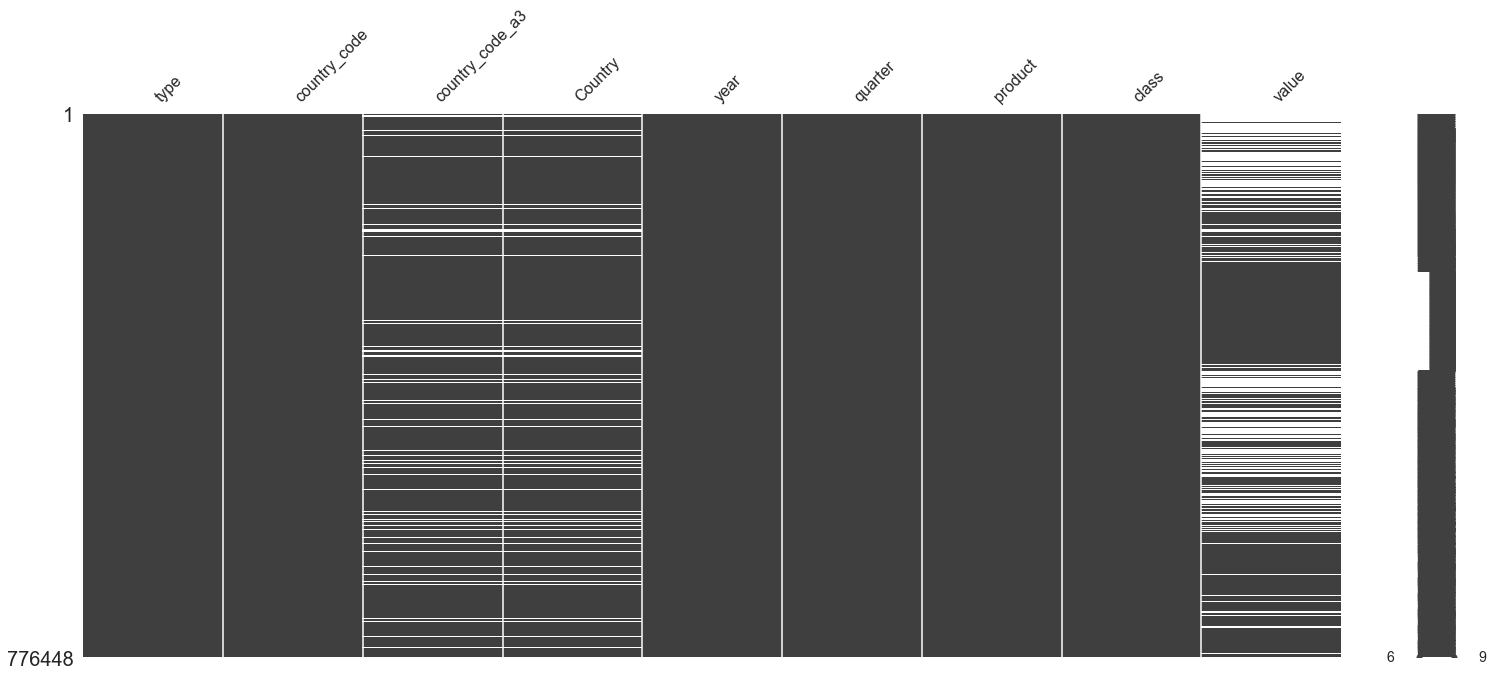

In [55]:
msno.matrix(input_output)

### Analysing the Missing Values in 'values' according to other variables

- Missing Values of 'values' per 'year'

In [56]:
null_counts_year = input_output.groupby('year')['value'].agg(total_values = 'size',missing_values = lambda x: x.isnull().sum())
null_counts_year['Missing_Values (%)'] = (null_counts_year['missing_values'] / null_counts_year['total_values']) * 100
null_counts_year= null_counts_year.sort_values(by = 'Missing_Values (%)', ascending = False).reset_index()
null_counts_year

,year,total_values,missing_values,Missing_Values (%)
0,2000,43136,37406,86.716432
1,2001,43136,29460,68.295623
2,2002,43136,28744,66.635757
3,2003,43136,28744,66.635757
4,2004,43136,28604,66.311202
5,2005,43136,21882,50.727930
6,2006,43136,14596,33.837166
7,2007,43136,12900,29.905415
8,2008,43136,11778,27.304340
9,2009,43136,11576,26.836053


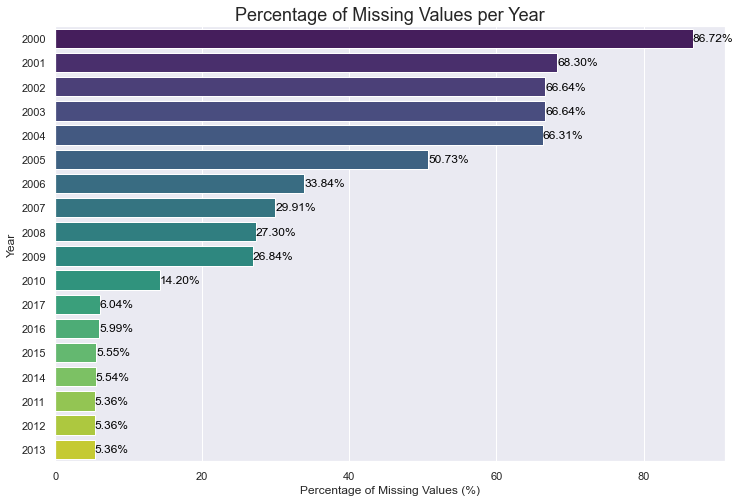

In [57]:
plt.figure(figsize = (12,8))
sns.barplot(x = null_counts_year['Missing_Values (%)'], y = null_counts_year['year'], palette = 'viridis' )
plt.title('Percentage of Missing Values per Year', fontsize=18)
plt.xlabel('Percentage of Missing Values (%)')
plt.ylabel('Year')

# dding Labels in the bars
for index, value in enumerate(null_counts_year['Missing_Values (%)']):
    plt.text(value, index, f'{value:.2f}%', color='black', ha='left', va='center')


- Missing Values of 'values' per 'class'

In [58]:
null_counts_class = input_output.groupby(['class'])['value'].agg(total_values = 'size', missing_values = lambda x: x.isnull().sum())
null_counts_class['Missing_Values (%)'] = (null_counts_class['missing_values'] / null_counts_class['total_values']) * 100
null_counts_class= null_counts_class.sort_values(by = 'Missing_Values (%)', ascending = False).reset_index()
null_counts_class

,class,total_values,missing_values,Missing_Values (%)
0,WINE,11520,4548,39.479167
1,OTHER CROP PRODUCTS,10656,4144,38.888889
2,INDUSTRIAL CROPS,46944,18208,38.786639
3,FORAGE PLANTS,14400,5542,38.486111
4,POTATOES,37440,14304,38.205128
5,FRUIT,52704,20084,38.107165
6,OLIVE OIL,2304,856,37.152778
7,MACHINERY AND OTHER EQUIPMENT,46368,16232,35.006901
8,CEREALS,70560,23678,33.557256
9,TRANSPORT EQUIPMENT,21024,6840,32.534247


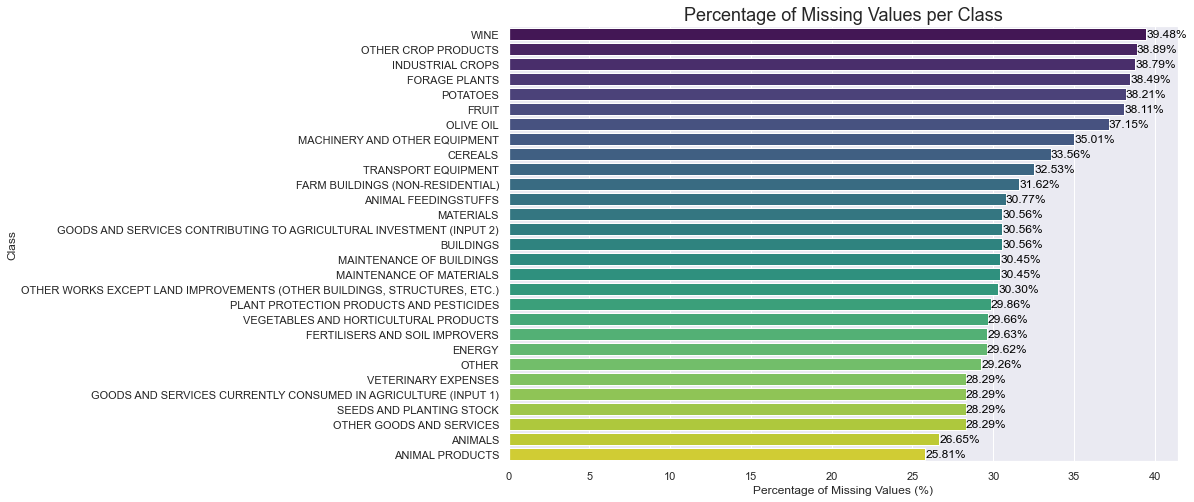

In [59]:
plt.figure(figsize = (12,8))
sns.barplot(x = null_counts_class['Missing_Values (%)'], y = null_counts_class['class'], palette = 'viridis' )
plt.title('Percentage of Missing Values per Class', fontsize=18)
plt.xlabel('Percentage of Missing Values (%)')
plt.ylabel('Class')

# dding Labels in the bars
for index, value in enumerate(null_counts_class['Missing_Values (%)']):
    plt.text(value, index, f'{value:.2f}%', color='black', ha='left', va='center')

- Missing Values of 'values' per 'Country'

In [60]:
null_counts_country = input_output.groupby(['Country','country_code'])['value'].agg(total_values = 'size', missing_values = lambda x: x.isnull().sum())
null_counts_country['Missing_Values (%)'] = (null_counts_country['missing_values'] / null_counts_country['total_values']) * 100
null_counts_country= null_counts_country.sort_values(by = 'Missing_Values (%)', ascending = False).reset_index()
null_counts_country

,Country,country_code,total_values,missing_values,Missing_Values (%)
0,Portugal,PT,33408,21516,64.403736
1,Germany,DE,22752,13692,60.179325
2,Italy,IT,31104,18534,59.587191
3,Ireland,IE,23328,12000,51.440329
4,Bulgaria,BG,28800,11430,39.687500
5,Hungary,HU,32544,12894,39.620206
6,Cyprus,CY,29376,11026,37.534041
7,Croatia,HR,32544,12194,37.469272
8,Sweden,SE,27072,9672,35.726950
9,Denmark,DK,28800,10150,35.243056


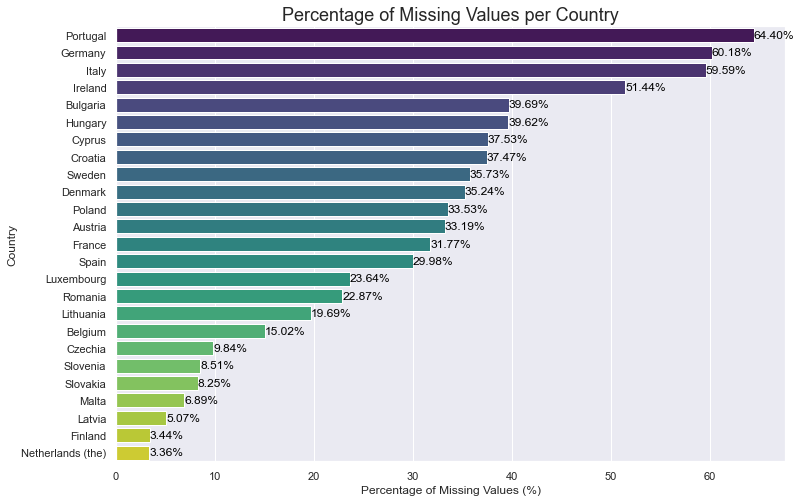

In [61]:
plt.figure(figsize = (12,8))
sns.barplot(x = null_counts_country['Missing_Values (%)'], y = null_counts_country['Country'], palette = 'viridis' )
plt.title('Percentage of Missing Values per Country', fontsize=18)
plt.xlabel('Percentage of Missing Values (%)')
plt.ylabel('Country')

# dding Labels in the bars
for index, value in enumerate(null_counts_country['Missing_Values (%)']):
    plt.text(value, index, f'{value:.2f}%', color='black', ha='left', va='center')


- Percentage of Missing Values Total

In [62]:
percentage_NA_Total = (input_output['value'].isnull().sum() / input_output['value'].size) * 100
percentage_NA_Total

32.033825832509066

### Treating Missing Values

- Dropping Missing Values

In [63]:
input_output = input_output.dropna()

- Plotting the Dataset after Missing Values Treatment

<AxesSubplot:>

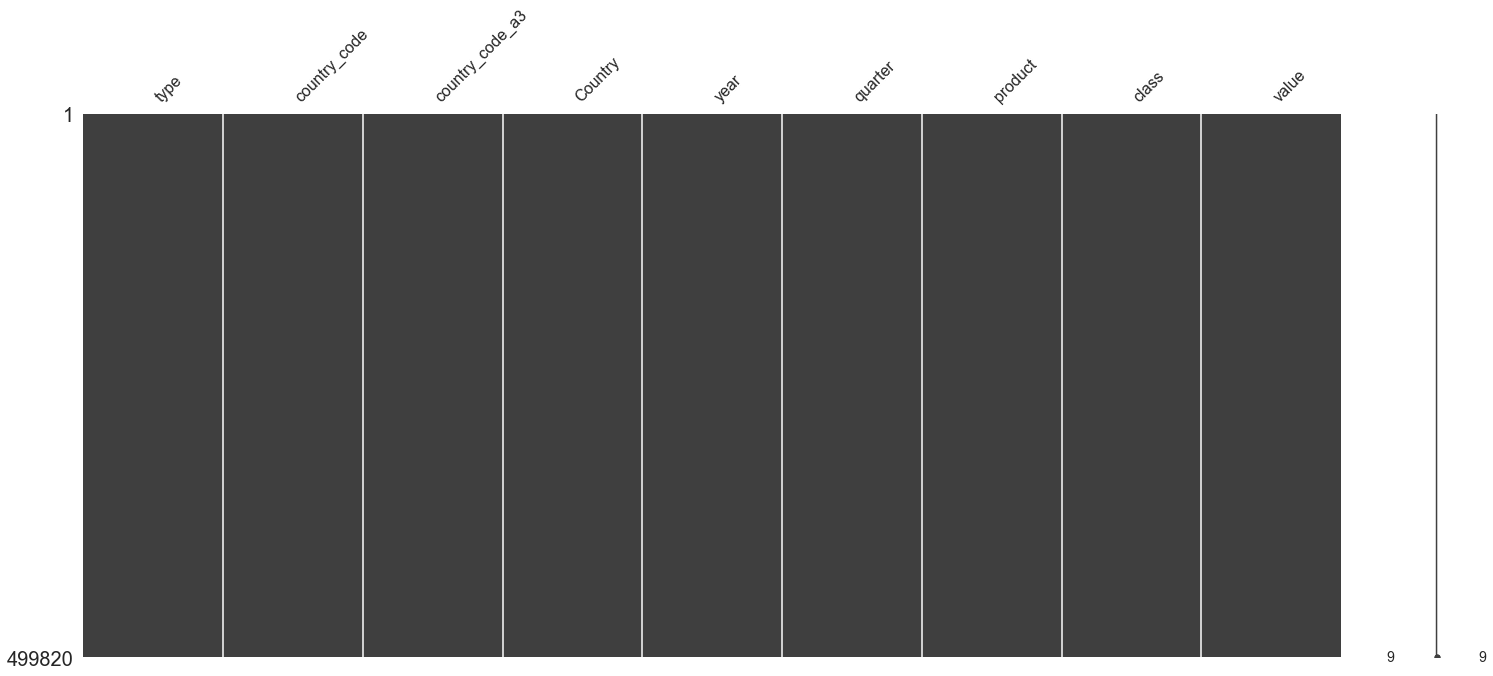

In [64]:
msno.matrix(input_output)

### Checking Years without Information

- Checking Years without Information per Country

In [65]:
pivot_table_year_country = input_output.pivot_table(index='country_code', columns='year', values='value', aggfunc='sum').reset_index()
pivot_table_year_country

year,country_code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,AT,NaN,NaN,NaN,NaN,NaN,75280.1,82529.7,99954.6,108674.2,84446.0,85042.9,107316.7,98987.3,101711.0,86229.2,90396.1,87776.4,89408.8
1,BE,NaN,70421.1,63960.1,71536.7,66392.2,64857.2,77668.0,80768.2,91013.9,59367.6,77350.4,87434.1,90858.7,86455.3,66767.5,79159.5,77438.1,80498.9
2,BG,NaN,NaN,NaN,NaN,NaN,NaN,64103.9,79785.9,84822.4,76059.9,75764.8,94958.1,92010.9,92799.6,82275.6,86912.7,82969.6,82132.9
3,CY,NaN,NaN,NaN,NaN,NaN,81813.4,84337.9,91402.4,100759.0,78345.6,66913.8,79906.5,83704.3,90209.0,84864.8,85812.1,94585.9,87077.6
4,CZ,69746.3,77410.9,68953.6,68994.2,73271.4,62863.6,71748.9,83132.8,84189.1,58670.7,73327.8,87311.9,81125.0,87230.9,77165.5,75612.3,72554.3,75337.7
5,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59747.9,77621.0,73230.8,74206.0,62044.0,67033.0,69223.0,71703.3
6,DK,NaN,NaN,NaN,NaN,NaN,66189.4,70268.7,82524.5,100638.7,65294.3,77055.3,94265.9,91421.8,94474.1,89760.0,87401.8,85464.7,89889.7
7,ES,51523.7,52781.0,50347.8,53424.9,51883.4,51057.1,47539.5,59540.7,59207.7,42306.1,92411.3,102818.9,107211.5,105757.0,88187.0,101850.3,96169.1,96554.3
8,FI,58576.1,60232.3,59536.4,60208.8,63203.1,60482.8,65704.5,73792.9,85230.8,60556.0,69524.6,87714.7,83370.8,85681.8,71473.0,74527.7,71326.8,74967.3
9,FR,NaN,NaN,NaN,NaN,NaN,78435.4,88051.1,102395.3,111026.7,79754.4,94313.0,111236.2,108228.0,108471.9,93682.5,96988.9,99609.3,99941.0


- Removing Years without Information

Removing years of the dataset where most of the countries don't have information, avoiding influence on results

In [66]:
input_output = input_output[~input_output['year'].isin(['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010'])]

# Exploratory Data Analysis (EDA)

## - Describing Variables

In [67]:
# Checking the dataset
input_output.head()

,type,country_code,country_code_a3,Country,year,quarter,product,class,value
238656,inputs,AT,AUT,Austria,2011,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,108.8
238657,inputs,BE,BEL,Belgium,2011,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,112.2
238658,inputs,BG,BGR,Bulgaria,2011,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,108.8
238659,inputs,CY,CYP,Cyprus,2011,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,100.2
238660,inputs,CZ,CZE,Czechia,2011,1,200000,GOODS AND SERVICES CURRENTLY CONSUMED IN AGRIC...,107.8


In [68]:
# Checking the variables format
input_output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259730 entries, 238656 to 853546
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   type             259730 non-null  object 
 1   country_code     259730 non-null  object 
 2   country_code_a3  259730 non-null  object 
 3   Country          259730 non-null  object 
 4   year             259730 non-null  object 
 5   quarter          259730 non-null  object 
 6   product          259730 non-null  object 
 7   class            259730 non-null  object 
 8   value            259730 non-null  float64
dtypes: float64(1), object(8)
memory usage: 19.8+ MB


In [69]:
## Describing numeric variables
input_output.describe()

,value
count,259730.000000
mean,57.177159
std,59.819649
min,-90.300000
25%,0.500000
50%,68.500000
75%,107.900000
max,1231.100000


In [70]:
## Describing discrete variables
input_output.describe(include = object)

,type,country_code,country_code_a3,Country,year,quarter,product,class
count,259730,259730,259730,259730,259730,259730,259730,259730
unique,2,25,25,25,7,8,129,29
top,outputs,FR,FRA,France,2011,3,200000,ANIMAL FEEDINGSTUFFS
freq,130022,12544,12544,12544,37208,34484,2800,28664


## - Graphical Analysis

### Data Overview 

- Plotting the histogram of Values with Agricultural Inputs and Outputs products together 

Text(10, 0, 'Note: Data with bimodal distribution and occurrence of outliers ')

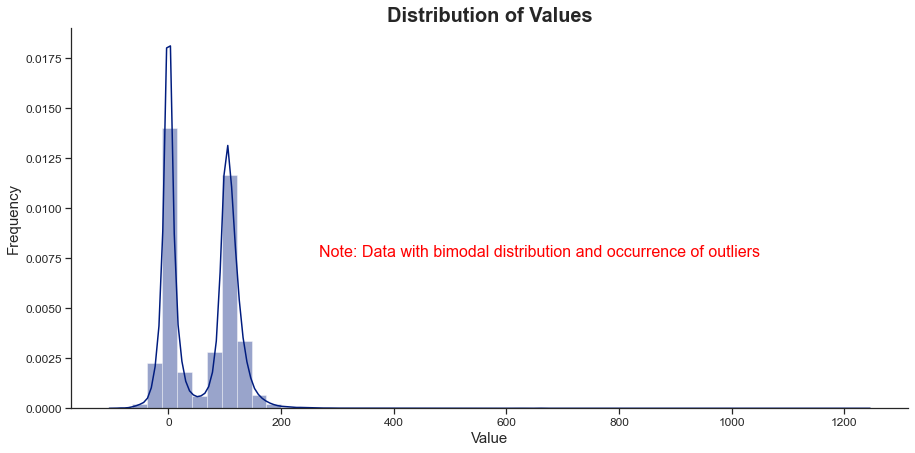

In [71]:
plt.figure(figsize=(15,7))                        # size of the figure
sns.set_theme(style="ticks", palette="dark")      # style of the graph
sns.distplot(input_output['value'], hist = True)  # histogram graph
plt.title('Distribution of Values', fontsize=20, fontweight='bold')      # title of the graph
plt.xlabel('Value', fontsize=15)                  # title and size of the x label
plt.ylabel('Frequency', fontsize=15)              # title and size of the y label
plt.xticks(fontsize=12)                           # size of the ticks
plt.yticks(fontsize=12)                           # size of the ticks
sns.despine()                                     # remove top and right edges for a more professional style

# Plotting notes about the graph
max_value = input_output['value'].max()
plt.annotate(f'Note: Data with bimodal distribution and occurrence of outliers ', xy=(250, 0.4), xycoords=('data', 'axes fraction'),
             xytext=(10, 0), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"), fontsize=16, color = 'red')


- Plotting the histogram of Values - Agricultural Inputs

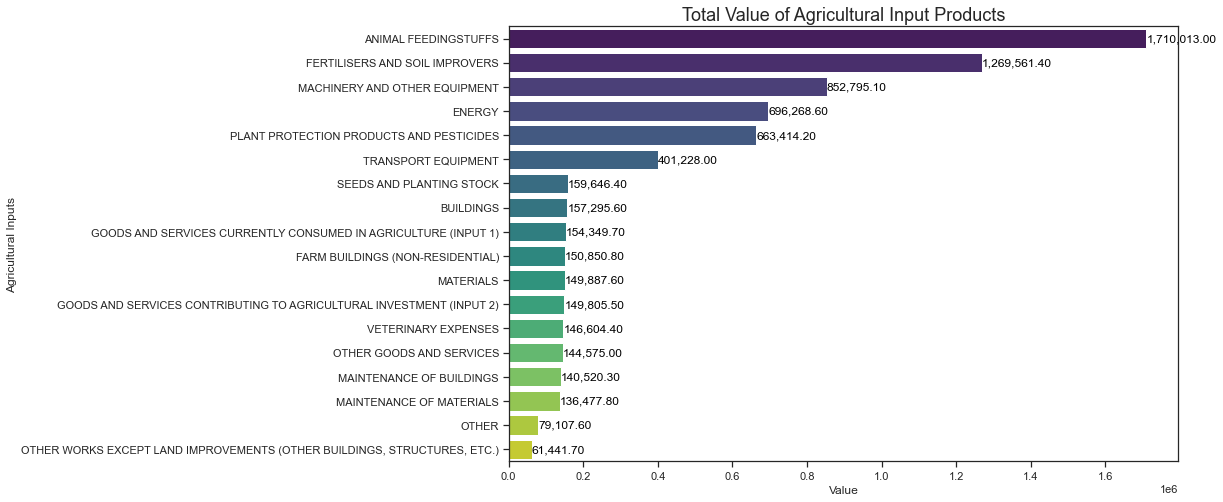

In [72]:
inputs_filt = input_output[input_output['type'] == 'inputs'].groupby('class')['value'].sum().reset_index()   # Table of Agricultural Inputs
inputs_filt= inputs_filt.sort_values(by = 'value', ascending = False).reset_index()                         # Sorting the data table

plt.figure(figsize = (12,8))          # size of the figure
sns.barplot(x = inputs_filt['value'], y = inputs_filt['class'], palette = 'viridis' )         # barplot graph
plt.title('Total Value of Agricultural Input Products', fontsize=18)        # title of the graph
plt.xlabel('Value')                                                         # title of the x label
plt.ylabel('Agricultural Inputs')                                           # title and size of the y label

# Adding Labels in the bars
for index, value in enumerate(inputs_filt['value']):
    formatted_value = format(value, ',.2f')  # formatting the number with decimal and thousands places 
    plt.text(value, index, formatted_value, color='black', ha='left', va='center')

- Plotting the histogram of Values - Agricultural Outputs

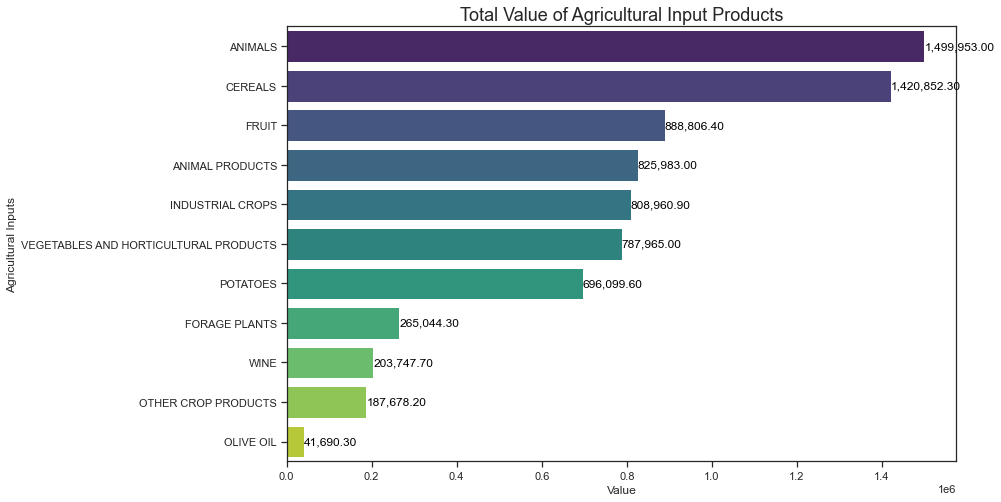

In [73]:
outputs_filt = input_output[input_output['type'] == 'outputs'].groupby('class')['value'].sum().reset_index()   # Table of Agricultural Outputs
outputs_filt= outputs_filt.sort_values(by = 'value', ascending = False).reset_index()                         # Sorting the data table

plt.figure(figsize = (12,8))          # size of the figure
sns.barplot(x = outputs_filt['value'], y = outputs_filt['class'], palette = 'viridis' )         # barplot graph
plt.title('Total Value of Agricultural Input Products', fontsize=18)        # title of the graph
plt.xlabel('Value')                                                         # title of the x label
plt.ylabel('Agricultural Inputs')                                           # title and size of the y label

# Adding Labels in the bars
for index, value in enumerate(outputs_filt['value']):
    formatted_value = format(value, ',.2f')  # formatting the number with decimal and thousands places 
    plt.text(value, index, formatted_value, color='black', ha='left', va='center')


- Plotting the Total Values of Agricultural Inputs and Products by Country

In [74]:
inputs_countrycode = input_output[input_output['type'] == 'inputs'].groupby('country_code')['value'].sum().reset_index()   # Table of Agricultural Inputs
inputs_countrycode= inputs_countrycode.sort_values(by = 'value', ascending = False).reset_index()

outputs_countrycode = input_output[input_output['type'] == 'outputs'].groupby('country_code')['value'].sum().reset_index()   # Table of Agricultural Inputs
outputs_countrycode= outputs_countrycode.sort_values(by = 'value', ascending = False).reset_index()

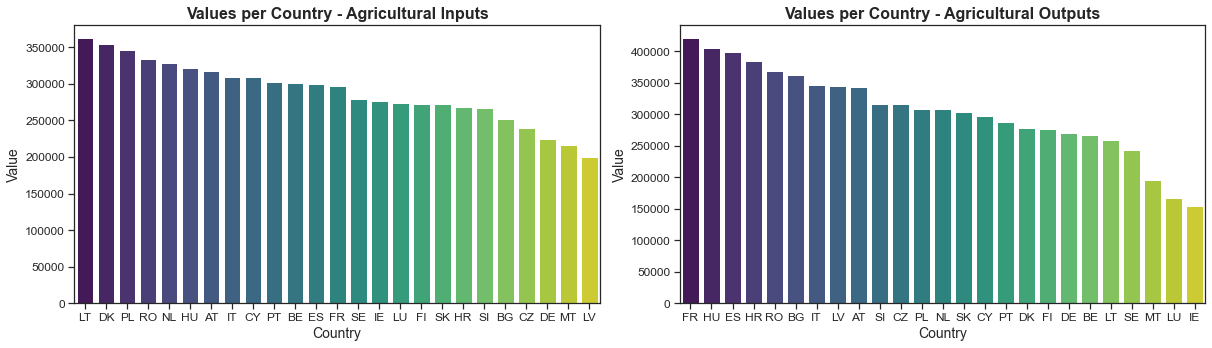

In [75]:
# Plotting the 'values' per country code 
plt.figure(figsize=(17,5))                                                      # size of the figure

plt.subplot(1,2,1)
sns.barplot(x = 'country_code', y = 'value', data = inputs_countrycode, palette='viridis')   # barplot graph
plt.title('Values per Country - Agricultural Inputs', fontsize=16, weight='bold')                        # title of the graph 
plt.xlabel('Country', fontsize=14)                                                 # title and size of the x label
plt.ylabel('Value', fontsize=14)                                                # title and size of the x label
plt.xticks(fontsize=12)                                                         # size of the x ticks
plt.yticks(fontsize=12)                                                         # size of the y ticks


plt.subplot(1,2,2)
sns.barplot(x = 'country_code', y = 'value', data = outputs_countrycode, palette='viridis')    # barplot graph
plt.title('Values per Country - Agricultural Outputs', fontsize=16, weight='bold') # title of the graph 
plt.xlabel('Country', fontsize=14)                                                 # title and size of the x label
plt.ylabel('Value', fontsize=14)                                                # title and size of the x label
plt.xticks(fontsize=12)                                                         # size of the x ticks
plt.yticks(fontsize=12)                                                         # size of the y ticks


plt.tight_layout()                                                              # adjusting layout
plt.show()                                                                      # show graph
 

- Plotting the Mean Values of Agricultural Inputs and Products by Country

In [76]:
inputs_countrycode = input_output[input_output['type'] == 'inputs'].groupby('country_code')['value'].mean().reset_index()   # Table of Agricultural Inputs
inputs_countrycode= inputs_countrycode.sort_values(by = 'value', ascending = False).reset_index()

outputs_countrycode = input_output[input_output['type'] == 'outputs'].groupby('country_code')['value'].mean().reset_index()   # Table of Agricultural Inputs
outputs_countrycode= outputs_countrycode.sort_values(by = 'value', ascending = False).reset_index()

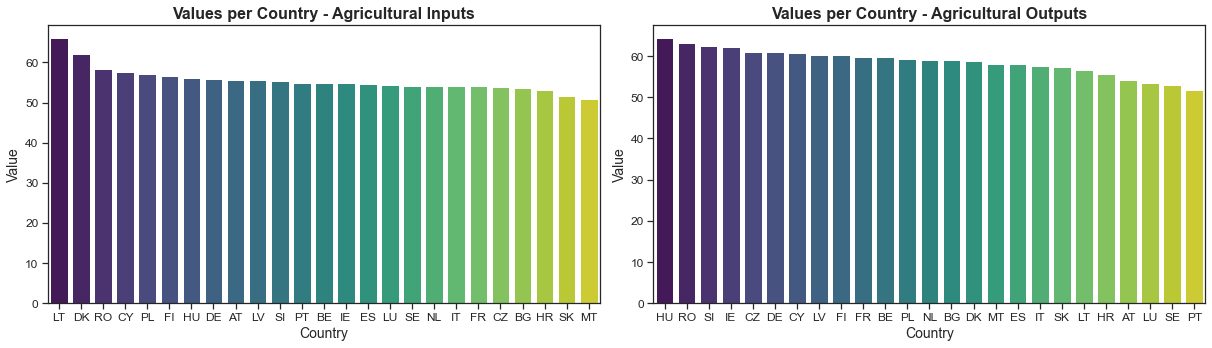

In [77]:
# Plotting the 'values' per country code 
plt.figure(figsize=(17,5))                                                      # size of the figure

plt.subplot(1,2,1)
sns.barplot(x = 'country_code', y = 'value', data = inputs_countrycode, palette='viridis')   # barplot graph
plt.title('Values per Country - Agricultural Inputs', fontsize=16, weight='bold')                        # title of the graph 
plt.xlabel('Country', fontsize=14)                                                 # title and size of the x label
plt.ylabel('Value', fontsize=14)                                                # title and size of the x label
plt.xticks(fontsize=12)                                                         # size of the x ticks
plt.yticks(fontsize=12)                                                         # size of the y ticks


plt.subplot(1,2,2)
sns.barplot(x = 'country_code', y = 'value', data = outputs_countrycode, palette='viridis')    # barplot graph
plt.title('Values per Country - Agricultural Outputs', fontsize=16, weight='bold') # title of the graph 
plt.xlabel('Country', fontsize=14)                                                 # title and size of the x label
plt.ylabel('Value', fontsize=14)                                                # title and size of the x label
plt.xticks(fontsize=12)                                                         # size of the x ticks
plt.yticks(fontsize=12)                                                         # size of the y ticks


plt.tight_layout()                                                              # adjusting layout
plt.show()                                                                      # show graph

 

### Ireland Overview

- Distribution of Agricultural Inputs and Outputs Products values - Overview

In [78]:
# Filtering Ireland's Agricultural Inputs and Outputs Products 
ireland_inputs_outputs = input_output[(input_output['country_code'] == 'IE')]

In [79]:
# Calculing the average for Ireland's Agricultural Inputs and Outputs Products 
mean_input_IE = ireland_inputs_outputs[input_output['type'] == 'inputs']['value'].mean()
mean_output_IE = ireland_inputs_outputs[input_output['type'] == 'outputs']['value'].mean()

'\n# Plotting notes about the graph\nmax_value = ireland_inputs_outputs[\'value\'].max()\nplt.annotate(f\'Note: Data with bimodal distribution and occurrence of outliers \', xy=(250, 0.4), xycoords=(\'data\', \'axes fraction\'),\n             xytext=(10, 0), textcoords=\'offset points\', arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"), fontsize=16, color = \'red\')\n'

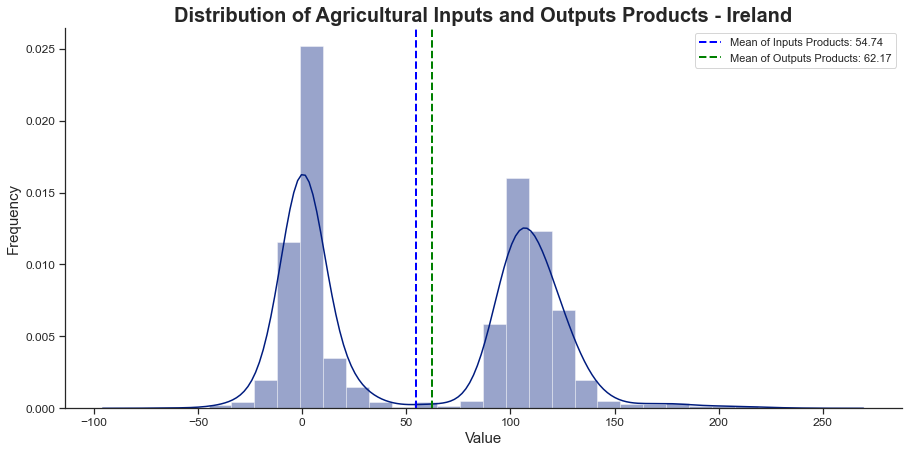

In [80]:
plt.figure(figsize=(15,7))                        # size of the figure
sns.set_theme(style="ticks", palette="dark")      # style of the graph
sns.distplot(ireland_inputs_outputs['value'], hist = True)  # histogram graph
plt.title('Distribution of Agricultural Inputs and Outputs Products - Ireland', fontsize=20, fontweight='bold')      # title of the graph
plt.xlabel('Value', fontsize=15)                  # title and size of the x label
plt.ylabel('Frequency', fontsize=15)              # title and size of the y label
plt.xticks(fontsize=12)                           # size of the ticks
plt.yticks(fontsize=12)                           # size of the ticks
sns.despine()                                     # remove top and right edges for a more professional style

# Adding the average lines in the graph 
plt.axvline(mean_input_IE, color='blue', linestyle='--', linewidth=2, label=f'Mean of Inputs Products: {mean_input_IE:.2f}')
plt.axvline(mean_output_IE, color='green', linestyle='--', linewidth=2, label=f'Mean of Outputs Products: {mean_output_IE:.2f}')
plt.legend()

'''
# Plotting notes about the graph
max_value = ireland_inputs_outputs['value'].max()
plt.annotate(f'Note: Data with bimodal distribution and occurrence of outliers ', xy=(250, 0.4), xycoords=('data', 'axes fraction'),
             xytext=(10, 0), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"), fontsize=16, color = 'red')
'''

- Distribution of Agricultural Inputs and Outputs Products values by class

In [81]:
inputs_IE = input_output[(input_output['type'] == 'inputs') & (input_output['country_code'] == 'IE')].groupby('class')['value'].sum().reset_index()   # Table of Agricultural Outputs
inputs_IE = inputs_IE.sort_values(by = 'value', ascending = False).reset_index()                         # Sorting the data table

outputs_IE = input_output[(input_output['type'] == 'outputs') & (input_output['country_code'] == 'IE')].groupby('class')['value'].sum().reset_index()   # Table of Agricultural Outputs
outputs_IE = outputs_IE.sort_values(by = 'value', ascending = False).reset_index()   

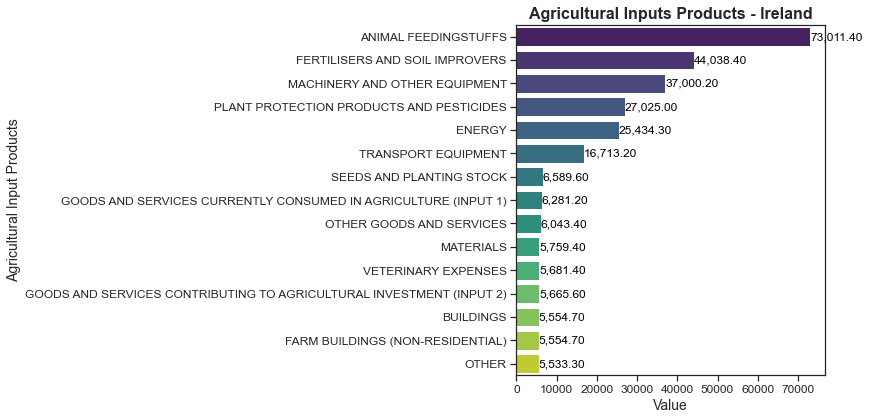

In [82]:
# Plotting the 'values' per class - Ireland 
plt.figure(figsize=(12,6))                                                      # size of the figure
sns.barplot(x = 'value', y = 'class', data = inputs_IE, palette='viridis')   # barplot graph
plt.title('Agricultural Inputs Products - Ireland', fontsize=16, weight='bold')                        # title of the graph 
plt.xlabel('Value', fontsize=14)                                                 # title and size of the x label
plt.ylabel('Agricultural Input Products', fontsize=14)                                                # title and size of the x label
plt.xticks(fontsize=12)                                                         # size of the x ticks
plt.yticks(fontsize=12)                                                         # size of the y ticks


# Adding Labels in the bars
for index, value in enumerate(inputs_IE['value']):
    formatted_value = format(value, ',.2f')  # formatting the number with decimal and thousands places 
    plt.text(value, index, formatted_value, color='black', ha='left', va='center')


plt.tight_layout()                                                              # adjusting layout
plt.show() 


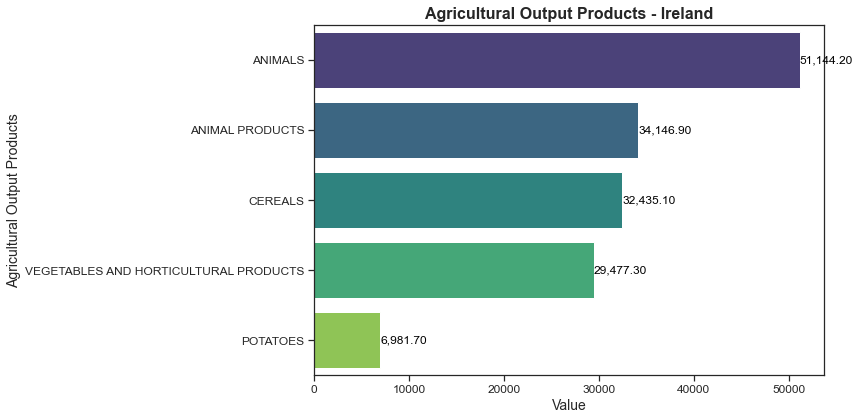

In [83]:
# Plotting the 'values' per class - Ireland 
plt.figure(figsize=(12,6))    
sns.barplot(x = 'value', y = 'class', data = outputs_IE, palette='viridis')    # barplot graph
plt.title('Agricultural Output Products - Ireland', fontsize=16, weight='bold') # title of the graph 
plt.xlabel('Value', fontsize=14)                                                 # title and size of the x label
plt.ylabel('Agricultural Output Products', fontsize=14)                                                # title and size of the x label
plt.xticks(fontsize=12)                                                         # size of the x ticks
plt.yticks(fontsize=12)                                                         # size of the y ticks

# Adding Labels in the bars
for index, value in enumerate(outputs_IE['value']):
    formatted_value = format(value, ',.2f')  # formatting the number with decimal and thousands places 
    plt.text(value, index, formatted_value, color='black', ha='left', va='center')


plt.tight_layout()                                                              # adjusting layout
plt.show()  

### Comparison of Ireland with Other European Union Countries

- Creating a table with Total Values for Agricultural Inputs and Outputs Products 

In [84]:
inp_out_totalcountry = input_output.pivot_table(index='Country', columns='type', values='value', aggfunc='sum').reset_index()

In [85]:
# Renaming and formating the columns
inp_out_totalcountry.columns.name = None  # Remove o nome da coluna
inp_out_totalcountry = inp_out_totalcountry.rename(columns={'inputs': 'Inputs', 'outputs': 'Outputs'})

In [86]:
# Creating a Total Columns and Ordering
inp_out_totalcountry['Total'] = inp_out_totalcountry[['Inputs', 'Outputs']].sum(axis=1)
inp_out_totalcountry = inp_out_totalcountry.sort_values(by = 'Total', ascending = False).reset_index() 

- Plotting the graph with the proportional participation per country of agricultural inputs and output products

In [87]:
# Calculate participation percentages
total_per_country = inp_out_totalcountry[['Inputs', 'Outputs']].sum(axis=1)  # Sum of Inputs and Outputs values
inputs_percentage = inp_out_totalcountry['Inputs'] / total_per_country * 100  # Percentual of Inputs
outputs_percentage = inp_out_totalcountry['Outputs'] / total_per_country * 100  # Percentual of Outputs

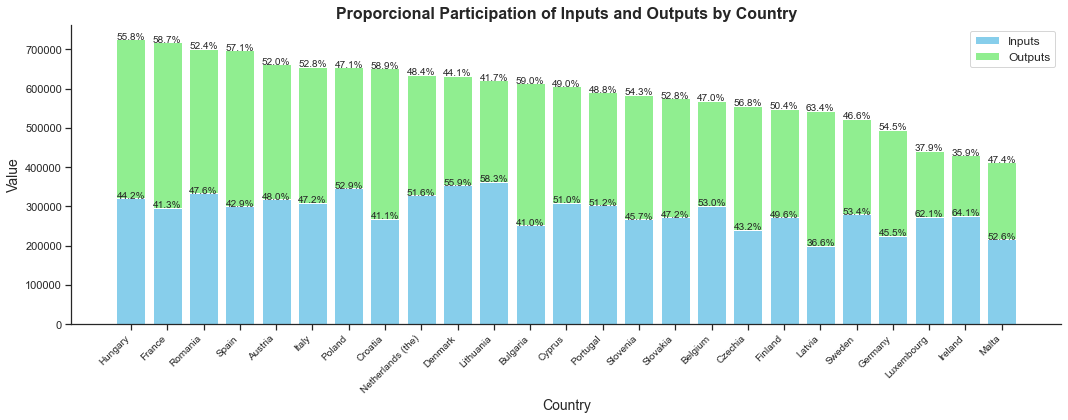

In [88]:
# Graph plotting
plt.figure(figsize=(15, 6))  # size of the graph

# Plot of bars for Inputs with percentages
bar1 = plt.bar(inp_out_totalcountry['Country'], inp_out_totalcountry['Inputs'], color='skyblue', label='Inputs')
for i, value in enumerate(inputs_percentage):
    plt.text(i, inp_out_totalcountry['Inputs'].iloc[i] + 1, f'{value:.1f}%', ha='center', fontsize=10)

# Plot of bars for Outputs with percentages
bar2 = plt.bar(inp_out_totalcountry['Country'], inp_out_totalcountry['Outputs'], bottom=inp_out_totalcountry['Inputs'], color='lightgreen', label='Outputs')
for i, value in enumerate(outputs_percentage):
    plt.text(i, inp_out_totalcountry['Inputs'].iloc[i] + inp_out_totalcountry['Outputs'].iloc[i] + 1, f'{value:.1f}%', ha='center', fontsize=10)

# Adding title and labels
plt.title('Proporcional Participation of Inputs and Outputs by Country', fontsize=16, fontweight='bold')
plt.xlabel('Country', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12)         # Adding legend
plt.xticks(rotation=45, ha='right', fontsize=10)   # Rotation of x-axis labels for better visualization
plt.gca().spines['top'].set_visible(False)         # Removing top and right borders from the chart
plt.gca().spines['right'].set_visible(False)       # Removing top and right borders from the chart

# Chart display
plt.tight_layout()
plt.show()

In [89]:
# Formatting the table with thousands and decimal separators
def format_value(value): 
    return f'{value:,.2f}' if pd.notnull(value) else ''

In [90]:
# Applying the function created to format with 'applymap'
inp_out_totalcountry[['Inputs', 'Outputs', 'Total']] = inp_out_totalcountry[['Inputs', 'Outputs', 'Total']].applymap(format_value)
inp_out_totalcountry

,index,Country,Inputs,Outputs,Total
0,10,Hungary,"321,022.90","405,477.60","726,500.50"
1,8,France,"296,889.60","421,268.20","718,157.80"
2,20,Romania,"333,954.50","368,349.30","702,303.80"
3,23,Spain,"299,935.20","398,612.90","698,548.10"
4,0,Austria,"317,842.80","343,982.70","661,825.50"
5,12,Italy,"309,491.20","346,199.50","655,690.70"
6,18,Poland,"345,842.50","308,325.40","654,167.90"
7,3,Croatia,"268,033.40","384,139.30","652,172.70"
8,17,Netherlands (the),"327,917.00","308,155.70","636,072.70"
9,6,Denmark,"353,924.60","278,753.40","632,678.00"


- Comparing Agricultural Input and Output Products: Mean of Ireland with Mean of European Union

In [91]:
# Creeating function to transform the dataset in IE and EU
def IE_EU_func(data):
    summary_EU = data[data['country_code'] != 'IE'].groupby(['type','year','quarter','product','class'])['value'].mean().reset_index()
    summary_EU['area'] = 'EU'
    summary_IE = data[data['country_code'] == 'IE'].groupby(['type','year','quarter','product','class'])['value'].mean().reset_index()
    summary_IE['area'] = 'IE'
    dd = pd.concat([summary_EU,summary_IE],ignore_index=True)
    return(dd)

In [92]:
# Applying the function
data_IE_EU = IE_EU_func(input_output)

In [93]:
# Calculing the mean for each area: EU and IE
eu_mean = data_IE_EU[(data_IE_EU['area'] == 'EU')]['value'].mean()
ie_mean = data_IE_EU[(data_IE_EU['area'] == 'IE')]['value'].mean()

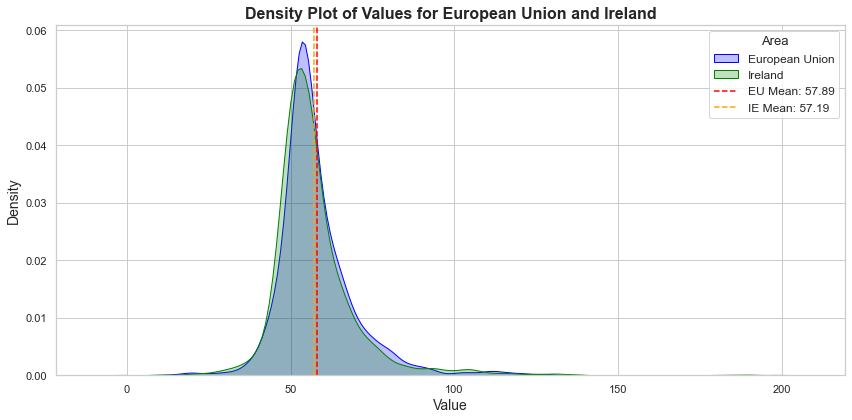

In [94]:
# Plotting the densite of EU and IE
plt.figure(figsize=(12, 6))  # size of the figure
sns.set_theme(style="whitegrid")  # style of the graph

# KDE plot fir 'EU' e 'IE'
sns.kdeplot(data=data_IE_EU[data_IE_EU['area'] == 'EU'], x='value', label='European Union', color='blue', fill=True)
sns.kdeplot(data=data_IE_EU[data_IE_EU['area'] == 'IE'], x='value', label='Ireland', color='green', fill=True)
plt.axvline(eu_mean, color='red', linestyle='--', linewidth=1.5, label=f'EU Mean: {eu_mean:.2f}')
plt.axvline(ie_mean, color='orange', linestyle='--', linewidth=1.5, label=f'IE Mean: {ie_mean:.2f}')

# Adding labels and title
plt.title('Density Plot of Values for European Union and Ireland', fontsize=16, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Adding legend
plt.legend(title='Area', title_fontsize='13', fontsize='12')

plt.tight_layout()
plt.show()

In [95]:
# Calculing the mean for each area: IE and EU
eu_mean_input = data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'inputs')]['value'].mean()
ie_mean_input = data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'inputs')]['value'].mean()

eu_mean_output = data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'outputs')]['value'].mean()
ie_mean_output = data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'outputs')]['value'].mean()

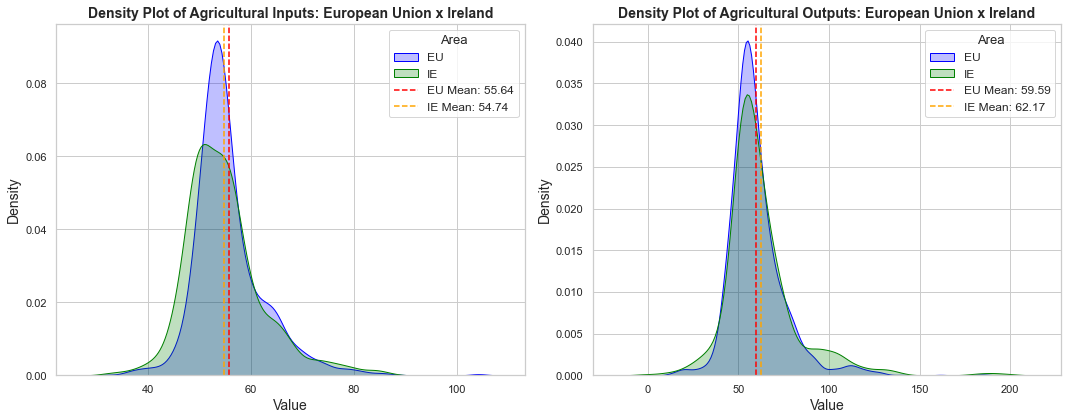

In [96]:
# Plotting the graphs side by side for mean of input and outputs: EU and IE
plt.figure(figsize=(15, 6))
sns.set_theme(style="whitegrid")

# KDE plot for 'inputs'
plt.subplot(1, 2, 1)
sns.kdeplot(data=data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'inputs')], x='value', label='EU', color='blue', fill=True)
sns.kdeplot(data=data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'inputs')], x='value', label='IE', color='green', fill=True)
plt.axvline(eu_mean_input, color='red', linestyle='--', linewidth=1.5, label=f'EU Mean: {eu_mean_input:.2f}')
plt.axvline(ie_mean_input, color='orange', linestyle='--', linewidth=1.5, label=f'IE Mean: {ie_mean_input:.2f}')
plt.title('Density Plot of Agricultural Inputs: European Union x Ireland', fontsize=14, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Area', title_fontsize='13', fontsize='12')

# KDE plot for 'outputs'
plt.subplot(1, 2, 2)
sns.kdeplot(data=data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'outputs')], x='value', label='EU', color='blue', fill=True)
sns.kdeplot(data=data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'outputs')], x='value', label='IE', color='green', fill=True)
plt.axvline(eu_mean_output, color='red', linestyle='--', linewidth=1.5, label=f'EU Mean: {eu_mean_output:.2f}')
plt.axvline(ie_mean_output, color='orange', linestyle='--', linewidth=1.5, label=f'IE Mean: {ie_mean_output:.2f}')
plt.title('Density Plot of Agricultural Outputs: European Union x Ireland', fontsize=14, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Area', title_fontsize='13', fontsize='12')

plt.tight_layout()
plt.show()

## - Outliers Analysis

### Checking the dataset considering variables Class and Country

- Plotting the data by Country to check the distribution

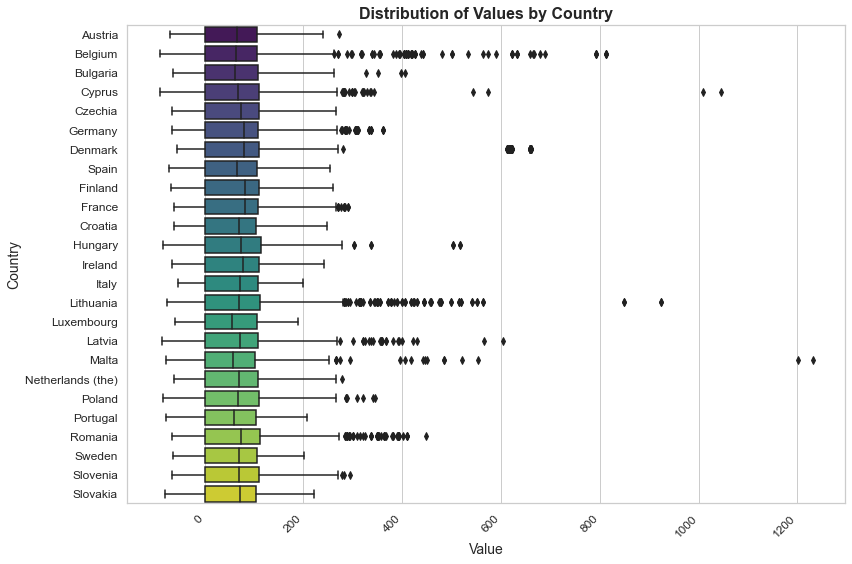

In [97]:
# Criando o gráfico boxplot
plt.figure(figsize=(12, 8))  # Tamanho da figura
sns.set_theme(style="whitegrid")  # Estilo do gráfico

# Criando o boxplot
boxplot = sns.boxplot(x='value', y='Country', data=input_output, palette='viridis')

# Adicionando título e rótulos
plt.title('Distribution of Values by Country', fontsize=16, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Country', fontsize=14)

# Adicionando escala de milhar e decimal ao eixo x
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

In [98]:
dist_country = input_output.groupby(['Country','country_code'])['value'].agg(mean_previous = 'mean', sd_previous = np.std).reset_index()
dist_country

,Country,country_code,mean_previous,sd_previous
0,Austria,AT,54.841357,55.948945
1,Belgium,BE,57.043750,68.475006
2,Bulgaria,BG,56.668457,58.319654
3,Croatia,HR,54.474833,56.172743
4,Cyprus,CY,58.987953,61.869322
5,Czechia,CZ,57.711369,58.298079
6,Denmark,DK,60.578131,68.933177
7,Finland,FI,58.361193,58.857083
8,France,FR,57.251100,58.284517
9,Germany,DE,58.545542,60.345841


- Plotting the data by Class to check the distribution

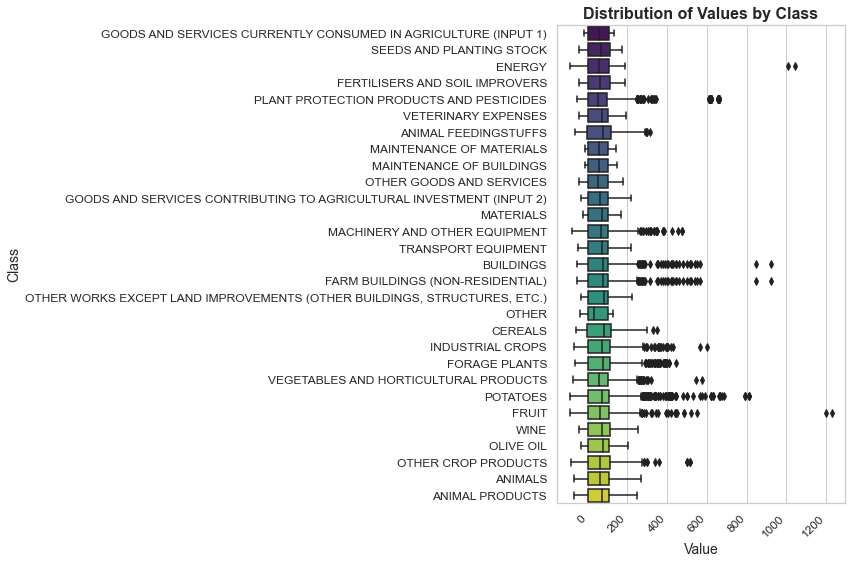

In [99]:
# Criando o gráfico boxplot
plt.figure(figsize=(12, 8))  # Tamanho da figura
sns.set_theme(style="whitegrid")  # Estilo do gráfico

# Criando o boxplot
boxplot = sns.boxplot(x='value', y='class', data=input_output, palette='viridis')

# Adicionando título e rótulos
plt.title('Distribution of Values by Class', fontsize=16, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Class', fontsize=14)

# Adicionando escala de milhar e decimal ao eixo x
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

In [100]:
dist_class = input_output.groupby(['class'])['value'].agg(mean_previous = 'mean', sd_previous = np.std).reset_index()
dist_class

,class,mean_previous,sd_previous
0,ANIMAL FEEDINGSTUFFS,59.657166,59.669849
1,ANIMAL PRODUCTS,57.280374,57.204542
2,ANIMALS,55.570280,55.593071
3,BUILDINGS,56.177000,67.524398
4,CEREALS,62.992210,65.008152
5,ENERGY,54.720890,57.181040
6,FARM BUILDINGS (NON-RESIDENTIAL),56.120089,68.000417
7,FERTILISERS AND SOIL IMPROVERS,56.235002,57.392348
8,FORAGE PLANTS,62.687867,68.846740
9,FRUIT,57.714701,61.456333


### Removing Outliers considering the variables Class and Country

- Creating function to remove outliers through Z-Score considering group of variables

In [101]:
def remove_outliers(df, value_column, group_columns, z_thresh=2):
    def remove_outliers(group):
        mean = group[value_column].mean()
        std = group[value_column].std()
        group['z_score'] = (group[value_column] - mean) / std
        return group[np.abs(group['z_score']) < z_thresh].drop(columns=['z_score'])
    
    return df.groupby(group_columns).apply(remove_outliers).reset_index(drop=True)

In [102]:
input_output_remv_outliers = remove_outliers(input_output, 'value', ['Country', 'class'])
input_output_remv_outliers

,type,country_code,country_code_a3,Country,year,quarter,product,class,value
0,inputs,AT,AUT,Austria,2011,1,206000,ANIMAL FEEDINGSTUFFS,118.3
1,inputs,AT,AUT,Austria,2011,1,206100,ANIMAL FEEDINGSTUFFS,135.3
2,inputs,AT,AUT,Austria,2011,1,206110,ANIMAL FEEDINGSTUFFS,163.8
3,inputs,AT,AUT,Austria,2011,1,206120,ANIMAL FEEDINGSTUFFS,112.5
4,inputs,AT,AUT,Austria,2011,1,206190,ANIMAL FEEDINGSTUFFS,156.1
...,...,...,...,...,...,...,...,...,...
258528,inputs,SE,SWE,Sweden,2017,3,205000,VETERINARY EXPENSES,1.8
258529,inputs,SE,SWE,Sweden,2017,4,205000,VETERINARY EXPENSES,122.6
258530,inputs,SE,SWE,Sweden,2017,4,205000,VETERINARY EXPENSES,7.3
258531,inputs,SE,SWE,Sweden,2017,4,205000,VETERINARY EXPENSES,114.0


In [103]:
dist_country_rmv_outliers = input_output_remv_outliers.groupby(['Country','country_code'])['value'].agg(mean_after = 'mean', sd_after = np.std).reset_index()
dist_class_rmv_outliers = input_output_remv_outliers.groupby(['class'])['value'].agg(mean_after = 'mean', sd_after = np.std).reset_index()

- Plotting the data by Country after removing Outliers

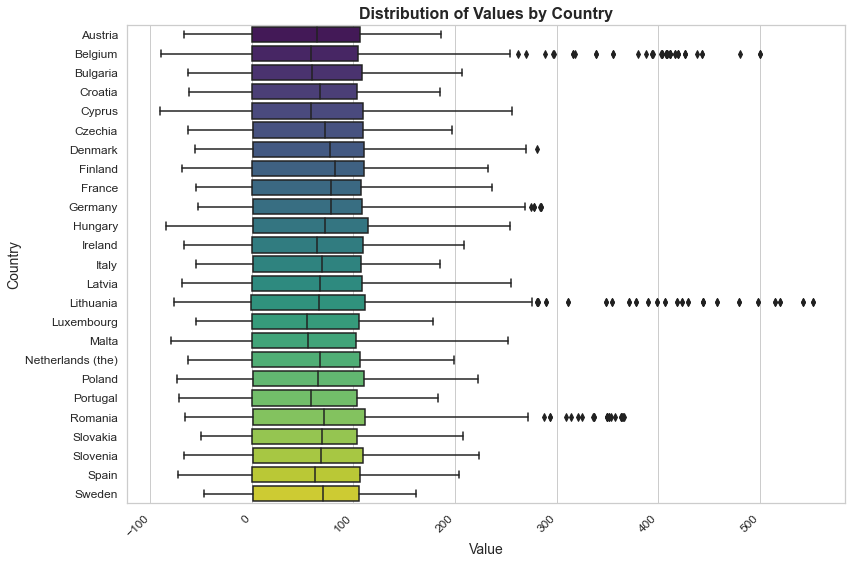

In [104]:
# Criando o gráfico boxplot
plt.figure(figsize=(12, 8))  # Tamanho da figura
sns.set_theme(style="whitegrid")  # Estilo do gráfico

# Criando o boxplot
boxplot = sns.boxplot(x='value', y='Country', data=input_output_remv_outliers, palette='viridis')

# Adicionando título e rótulos
plt.title('Distribution of Values by Country', fontsize=16, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Country', fontsize=14)

# Adicionando escala de milhar e decimal ao eixo x
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

In [105]:
dist_country[['mean_after','sd_after']] = dist_country_rmv_outliers[['mean_after','sd_after']] 
dist_country

,Country,country_code,mean_previous,sd_previous,mean_after,sd_after
0,Austria,AT,54.841357,55.948945,54.605638,55.534529
1,Belgium,BE,57.043750,68.475006,54.958083,61.248362
2,Bulgaria,BG,56.668457,58.319654,56.265038,57.726402
3,Croatia,HR,54.474833,56.172743,53.860232,55.514390
4,Cyprus,CY,58.987953,61.869322,57.640911,58.311971
5,Czechia,CZ,57.711369,58.298079,57.494354,57.973992
6,Denmark,DK,60.578131,68.933177,58.196323,58.969608
7,Finland,FI,58.361193,58.857083,58.202298,58.628802
8,France,FR,57.251100,58.284517,56.416143,57.156098
9,Germany,DE,58.545542,60.345841,57.348846,58.199986


- Plotting the data by Class after removing Outliers

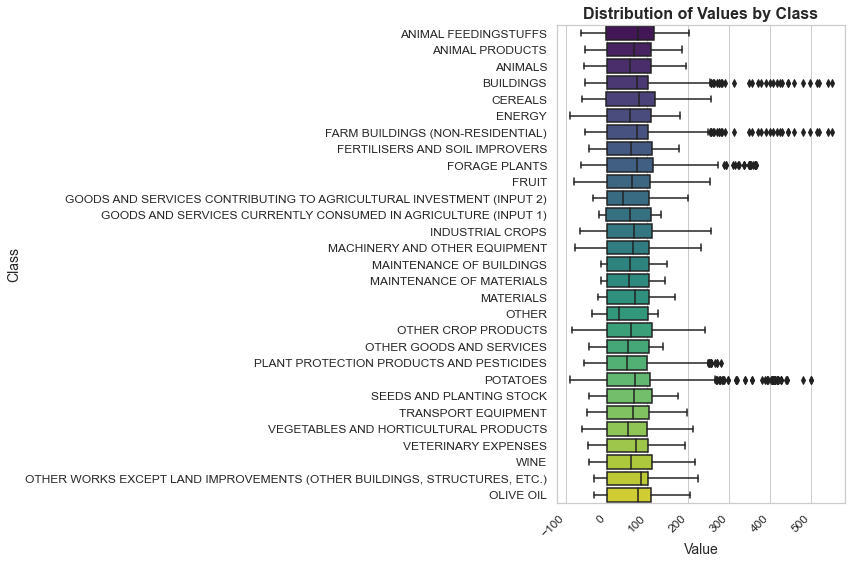

In [106]:
# Criando o gráfico boxplot
plt.figure(figsize=(12, 8))  # Tamanho da figura
sns.set_theme(style="whitegrid")  # Estilo do gráfico

# Criando o boxplot
boxplot = sns.boxplot(x='value', y='class', data=input_output_remv_outliers, palette='viridis')

# Adicionando título e rótulos
plt.title('Distribution of Values by Class', fontsize=16, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Class', fontsize=14)

# Adicionando escala de milhar e decimal ao eixo x
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

In [107]:
dist_class[['mean_after','sd_after']] = dist_class_rmv_outliers[['mean_after','sd_after']] 
dist_class

,class,mean_previous,sd_previous,mean_after,sd_after
0,ANIMAL FEEDINGSTUFFS,59.657166,59.669849,59.243788,59.141746
1,ANIMAL PRODUCTS,57.280374,57.204542,56.579670,56.449255
2,ANIMALS,55.570280,55.593071,55.277305,55.195593
3,BUILDINGS,56.177000,67.524398,55.401752,63.066137
4,CEREALS,62.992210,65.008152,62.565167,64.567521
5,ENERGY,54.720890,57.181040,54.491726,55.804449
6,FARM BUILDINGS (NON-RESIDENTIAL),56.120089,68.000417,55.312439,63.383825
7,FERTILISERS AND SOIL IMPROVERS,56.235002,57.392348,56.229059,57.386672
8,FORAGE PLANTS,62.687867,68.846740,60.989833,65.414564
9,FRUIT,57.714701,61.456333,55.931975,57.228752


### Explanation about Z-Score

The `z_thresh` is a threshold used in statistics to identify outliers based on the z-score. The z-score, also known as the standard score, measures the distance of a data point from the mean in terms of standard deviations. In other words, the z-score indicates how many standard deviations a value is above or below the mean.

- **Formula**: The z-score of a value \( x \) is calculated as:
  \[
  z = \frac{x - \mu}{\sigma}
  \]
  where:
  - \( x \) is the individual value.
  - \( \mu \) is the mean of the sample or population.
  - \( \sigma \) is the standard deviation of the sample or population.
  
- Interpreting the z-score
- **z = 0**: The value is exactly at the mean.
- **z = 1**: The value is one standard deviation above the mean.
- **z = -1**: The value is one standard deviation below the mean.
- Larger absolute values indicate that the value is farther from the mean.

- Threshold z_thresh
- The `z_thresh` defines the cutoff point for considering a value as an outlier.
- Common values for `z_thresh`:
  - **z_thresh = 2**: Approximately 95% of the data is within 2 standard deviations from the mean. Values outside this range are considered outliers.
  - **z_thresh = 3**: Approximately 99.7% of the data is within 3 standard deviations from the mean. This is a more stringent criterion for identifying outliers.
  
- Choosing the z_thresh
- **Lower z_thresh**: Identifies more values as outliers, useful in situations where a more conservative analysis is desired, and high variability is expected in the data.
- **Higher z_thresh**: Identifies fewer values as outliers, useful when you want to be more tolerant of data variability and only remove the most extreme cases.

- Considerations
- **Data with Different Distributions**: If the data from different groups (such as countries and classes) have very different distributions, it is important to remove the outliers by group for more accurate analysis.
- **Impact of Outliers**: The presence of outliers can distort descriptive statistics (mean, standard deviation, etc.), so removing them can lead to a more accurate representation of the data.
- **Visual Validation**: After removing outliers, it is recommended to visually validate (e.g., using plots) to ensure that the removal was appropriate.

When choosing the `z_thresh`, consider balancing between identifying truly extreme values and preserving relevant data. Removing outliers can improve the quality of the analysis, but it should be done carefully to avoid excluding valid data that is merely extreme in a specific context.

- Redefining the Oficial Dataset - Replacing Using Dataset Without Outliers 

In [108]:
# Using the dataset without outliers and applying the function to transform the other countries in EU
input_output = input_output_remv_outliers
data_IE_EU = IE_EU_func(input_output_remv_outliers)

# Statistical Analysis

- The statistical analysis are going to be based in the dataset tranformed for two groups: 
    - Agricultural Inputs and Outputs Products - Ireland
    - Agricultural Inputs and Outputs Products - European Union 

## - Measures of Central Tendency

### Mean 

In [109]:
# Calculating the MEAN for Agricultural Inputs and Outputs - Ireland and European
inputs_IE_mean = data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'inputs')]['value'].mean()
outputs_IE_mean = data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'outputs')]['value'].mean()
inputs_EU_mean = data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'inputs')]['value'].mean()
outputs_EU_mean = data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'outputs')]['value'].mean()
print(f'Mean of Agricultural Inputs Products - Ireland: {inputs_IE_mean}')
print(f'Mean of Agricultural Outputs Products - Ireland: {outputs_IE_mean}')
print(f'Mean of Agricultural Inputs Products - European Union: {inputs_EU_mean}')
print(f'Mean of Agricultural Outputs Products - European Union: {outputs_EU_mean}')

Mean of Agricultural Inputs Products - Ireland: 54.739246031746056
Mean of Agricultural Outputs Products - Ireland: 60.106075268817186
Mean of Agricultural Inputs Products - European Union: 55.11739200883865
Mean of Agricultural Outputs Products - European Union: 58.06774575987884


### Median

In [110]:
# Calculating the MEDIAN for Agricultural Inputs and Outputs - Ireland and European
inputs_IE_median= data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'inputs')]['value'].median()
outputs_IE_median = data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'outputs')]['value'].median()
inputs_EU_median = data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'inputs')]['value'].median()
outputs_EU_median = data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'outputs')]['value'].median()
print(f'Median of Agricultural Inputs Products - Ireland: {inputs_IE_median}')
print(f'Median of Agricultural Outputs Products - Ireland: {outputs_IE_median}')
print(f'Median of Agricultural Inputs Products - European Union: {inputs_EU_median}')
print(f'Median of Agricultural Outputs Products - European Union: {outputs_EU_median}')

Median of Agricultural Inputs Products - Ireland: 53.525
Median of Agricultural Outputs Products - Ireland: 56.5
Median of Agricultural Inputs Products - European Union: 53.953125
Median of Agricultural Outputs Products - European Union: 55.997058823529414


### Trimmed Mean

In [111]:
# Calculating the Trimmed Mean by dropping 20% for Agricultural Inputs and Outputs - Ireland and European
inputs_IE_trimean = stats.trim_mean(data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'inputs')]['value'],0.2)
outputs_IE_trimean = stats.trim_mean(data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'outputs')]['value'],0.2)
inputs_EU_trimean = stats.trim_mean(data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'inputs')]['value'],0.2)
outputs_EU_trimean = stats.trim_mean(data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'outputs')]['value'],0.2)
print(f'Trimmed Mean of Agricultural Inputs Products - Ireland: {inputs_IE_trimean}')
print(f'Trimmed Mean of Agricultural Outputs Products - Ireland: {outputs_IE_trimean}')
print(f'Trimmed Mean of Agricultural Inputs Products - European Union: {inputs_EU_trimean}')
print(f'Trimmed Mean of Agricultural Outputs Products - European Union: {outputs_EU_trimean}')

Trimmed Mean of Agricultural Inputs Products - Ireland: 53.66412037037037
Trimmed Mean of Agricultural Outputs Products - Ireland: 57.626926523297485
Trimmed Mean of Agricultural Inputs Products - European Union: 54.093457579185966
Trimmed Mean of Agricultural Outputs Products - European Union: 56.33452202241402


## - Variability Measures

### Amplitude

In [112]:
amplitude_IE_inputs = data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'inputs')]['value'].max() - data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'inputs')]['value'].min()
amplitude_IE_outputs = data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'outputs')]['value'].max() - data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'outputs')]['value'].min()
amplitude_EU_inputs = data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'inputs')]['value'].max() - data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'inputs')]['value'].min()
amplitude_EU_outputs = data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'outputs')]['value'].max() - data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'outputs')]['value'].min()
print(f'Amplitude of Agricultural Inputs Products - Ireland: {amplitude_IE_inputs}')
print(f'Amplitude of Agricultural Agricultural Outputs Products - Ireland: {amplitude_IE_outputs}')
print(f'Amplitude of Agricultural Agricultural Inputs Products - European Union: {amplitude_EU_inputs}')
print(f'Amplitude of Agricultural Agricultural Outputs Products - European Union: {amplitude_EU_outputs}')

Amplitude of Agricultural Inputs Products - Ireland: 55.150000000000006
Amplitude of Agricultural Agricultural Outputs Products - Ireland: 210.06666666666666
Amplitude of Agricultural Agricultural Inputs Products - European Union: 72.5141304347826
Amplitude of Agricultural Agricultural Outputs Products - European Union: 143.09984802431612


### Variance

In [113]:
var_IE_inputs = data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'inputs')]['value'].var()
var_IE_outputs = data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'outputs')]['value'].var()
var_EU_inputs = data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'inputs')]['value'].var()
var_EU_outputs = data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'outputs')]['value'].var()
print(f'Variance of Agricultural Inputs Products - Ireland: {var_IE_inputs}')
print(f'Variance of Agricultural Agricultural Outputs Products - Ireland: {var_IE_outputs}')
print(f'Variance of Agricultural Agricultural Inputs Products - European Union: {var_EU_inputs}')
print(f'Variance of Agricultural Agricultural Outputs Products - European Union: {var_EU_outputs}')

Variance of Agricultural Inputs Products - Ireland: 59.22358064633062
Variance of Agricultural Agricultural Outputs Products - Ireland: 394.4284538769312
Variance of Agricultural Agricultural Inputs Products - European Union: 42.42830333358201
Variance of Agricultural Agricultural Outputs Products - European Union: 187.71209253170701


### Standard Deviation

In [114]:
sd_IE_inputs = data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'inputs')]['value'].std()
sd_IE_outputs = data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'outputs')]['value'].std()
sd_EU_inputs = data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'inputs')]['value'].std()
sd_EU_outputs = data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'outputs')]['value'].std()
print(f'Standard Deviation of Agricultural Inputs Products - Ireland: {sd_IE_inputs}')
print(f'Standard Deviation of Agricultural Agricultural Outputs Products - Ireland: {sd_IE_outputs}')
print(f'Standard Deviation of Agricultural Agricultural Inputs Products - European Union: {sd_EU_inputs}')
print(f'Standard Deviation of Agricultural Agricultural Outputs Products - European Union: {sd_EU_outputs}')

Standard Deviation of Agricultural Inputs Products - Ireland: 7.695685846390211
Standard Deviation of Agricultural Agricultural Outputs Products - Ireland: 19.860222906023264
Standard Deviation of Agricultural Agricultural Inputs Products - European Union: 6.513701200821389
Standard Deviation of Agricultural Agricultural Outputs Products - European Union: 13.700806273052219


### Coefficient of variation

In [115]:
coefvar_IE_inputs = (sd_IE_inputs / inputs_IE_mean) * 100
coefvar_outputs = (sd_IE_outputs / outputs_IE_mean) * 100
coefvar_inputs = (sd_EU_inputs / inputs_EU_mean) * 100
coefvar_outputs = (sd_EU_outputs / outputs_EU_mean) * 100
print(f'Coefficient of Variation of Agricultural Inputs Products - Ireland: {coefvar_IE_inputs}')
print(f'Coefficient of Variation of Agricultural Agricultural Outputs Products - Ireland: {coefvar_outputs}')
print(f'Coefficient of Variation of Agricultural Agricultural Inputs Products - European Union: {coefvar_inputs}')
print(f'Coefficient of Variation of Agricultural Agricultural Outputs Products - European Union: {coefvar_outputs}')

Coefficient of Variation of Agricultural Inputs Products - Ireland: 14.058808632342313
Coefficient of Variation of Agricultural Agricultural Outputs Products - Ireland: 23.594520665065346
Coefficient of Variation of Agricultural Agricultural Inputs Products - European Union: 11.817869030843928
Coefficient of Variation of Agricultural Agricultural Outputs Products - European Union: 23.594520665065346


## Inferential Statistics

- The purpose of this topic is to make population statistical inferences based on sample estimators.

### Sampling the Dataset

- Creating a Stratified Sampling considering variables Area, Type, Class and Year

In [116]:
# Defining a function to make a stratified sampling
def stratified_sampling(df, strata, frac=0.1, random_state=None):
    return df.groupby(strata, group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=random_state))
'''
Parameters:
     df (pd.DataFrame): The DataFrame to sample.
     strata (list): List of columns to be used as strata.
     frac (float): Fraction of samples to be taken from each stratum.
     random_state (int): Seed for generating random numbers.
'''

'\nParameters:\n     df (pd.DataFrame): The DataFrame to sample.\n     strata (list): List of columns to be used as strata.\n     frac (float): Fraction of samples to be taken from each stratum.\n     random_state (int): Seed for generating random numbers.\n'

In [117]:
data_IE_EU_sample = stratified_sampling(data_IE_EU, ['area','type','class', 'year'],frac = 0.1, random_state = 20)
data_IE_EU_sample

,type,year,quarter,product,class,value,area
27,inputs,2011,1,206130,ANIMAL FEEDINGSTUFFS,55.036364,EU
31,inputs,2011,1,206220,ANIMAL FEEDINGSTUFFS,68.246429,EU
89,inputs,2011,2,206290,ANIMAL FEEDINGSTUFFS,66.363235,EU
199,inputs,2011,4,206290,ANIMAL FEEDINGSTUFFS,59.788235,EU
24,inputs,2011,1,206100,ANIMAL FEEDINGSTUFFS,81.664583,EU
...,...,...,...,...,...,...,...
5235,outputs,2015,3,041200,VEGETABLES AND HORTICULTURAL PRODUCTS,54.325000,IE
5348,outputs,2016,4,041000,VEGETABLES AND HORTICULTURAL PRODUCTS,52.400000,IE
5327,outputs,2016,3,041200,VEGETABLES AND HORTICULTURAL PRODUCTS,54.450000,IE
5440,outputs,2017,4,041000,VEGETABLES AND HORTICULTURAL PRODUCTS,51.725000,IE


### Size of Population and Sample Data

In [118]:
n_populational = len(data_IE_EU)
n_populational

5457

In [119]:
n_sample = len(data_IE_EU_sample)
n_sample

473

### Estimating Population Parameters

- POPULATION MEAN - To estimate the Population Mean, it is statistically proven that the sample mean is the best estimator.

In [120]:
mean_estimates_input_IE = data_IE_EU_sample[(data_IE_EU_sample['area'] == 'IE') & (data_IE_EU_sample['type'] == 'inputs')]['value'].mean()
mean_estimates_output_IE = data_IE_EU_sample[(data_IE_EU_sample['area'] == 'IE') & (data_IE_EU_sample['type'] == 'outputs')]['value'].mean()
mean_estimates_input_EU = data_IE_EU_sample[(data_IE_EU_sample['area'] == 'EU') & (data_IE_EU_sample['type'] == 'inputs')]['value'].mean()
mean_estimates_output_EU = data_IE_EU_sample[(data_IE_EU_sample['area'] == 'EU') & (data_IE_EU_sample['type'] == 'outputs')]['value'].mean()

- POPULATION STANDARD DEVIATION - To estimate the Population Standard Deviation, it is statistically proven that the sample standard deviation is the best estimator.

In [121]:
sd_estimates_input_IE = data_IE_EU_sample[(data_IE_EU_sample['area'] == 'IE') & (data_IE_EU_sample['type'] == 'inputs')]['value'].std()
sd_estimates_output_IE = data_IE_EU_sample[(data_IE_EU_sample['area'] == 'IE') & (data_IE_EU_sample['type'] == 'outputs')]['value'].std()
sd_estimates_input_EU = data_IE_EU_sample[(data_IE_EU_sample['area'] == 'EU') & (data_IE_EU_sample['type'] == 'inputs')]['value'].std()
sd_estimates_output_EU = data_IE_EU_sample[(data_IE_EU_sample['area'] == 'EU') & (data_IE_EU_sample['type'] == 'outputs')]['value'].std()

- CONFIDENCE INTERVAL OF THE POPULATION MEAN - We use the sample mean, sample standard deviation and sample size n, in addition to the confidence level Z-score (Normal Distribution), to define a confidence interval for the population mean.

In [122]:
confidence_level = 0.95     # Confidence level with 95%

In [123]:
# Defining the size's samples
n_input_IE = len(data_IE_EU_sample[(data_IE_EU_sample['area'] == 'IE') & (data_IE_EU_sample['type'] == 'inputs')]['value'])
n_output_IE = len(data_IE_EU_sample[(data_IE_EU_sample['area'] == 'IE') & (data_IE_EU_sample['type'] == 'outputs')]['value'])
n_input_EU = len(data_IE_EU_sample[(data_IE_EU_sample['area'] == 'EU') & (data_IE_EU_sample['type'] == 'inputs')]['value'])
n_output_EU = len(data_IE_EU_sample[(data_IE_EU_sample['area'] == 'EU') & (data_IE_EU_sample['type'] == 'outputs')]['value'])

In [124]:
# Z-Score for confidence level
z_score = stats.norm.ppf((1+confidence_level)/2)

In [125]:
# Confidence Interval
confidence_interval_mean_input_IE = (mean_estimates_input_IE - z_score * (sd_estimates_input_IE / np.sqrt(n_input_IE)),
                                     mean_estimates_input_IE + z_score * (sd_estimates_input_IE / np.sqrt(n_input_IE)))
confidence_interval_mean_output_IE = (mean_estimates_output_IE - z_score * (sd_estimates_output_IE / np.sqrt(n_output_IE)),
                                     mean_estimates_output_IE + z_score * (sd_estimates_output_IE / np.sqrt(n_output_IE)))
confidence_interval_mean_input_EU = (mean_estimates_input_EU - z_score * (sd_estimates_input_EU / np.sqrt(n_input_EU)),
                                     mean_estimates_input_EU + z_score * (sd_estimates_input_EU / np.sqrt(n_input_EU)))
confidence_interval_mean_output_EU = (mean_estimates_output_EU - z_score * (sd_estimates_output_EU / np.sqrt(n_output_EU)),
                                     mean_estimates_output_EU + z_score * (sd_estimates_output_EU / np.sqrt(n_output_EU)))

In [126]:
## Population Parameters and Estimates

print('')
print(f'POPULATION MEAN AND ESTIMATES:')
print(f'  Agricultural INPUTS Products:')
print(f'      - IRELAND ') 
print(f'            - Population Mean: {inputs_IE_mean}') 
print(f'            - Estimated Sample Mean: {mean_estimates_input_IE}') 
print(f'      - EUROPEAN UNION:') 
print(f'            - Population Mean: {inputs_EU_mean}') 
print(f'            - Estimated Sample Mean: {mean_estimates_input_EU}') 
print('------------------------------------------') 
print(f'  Agricultural OUTPUTS Products:')
print(f'      - IRELAND ') 
print(f'            - Population Mean: {outputs_IE_mean}') 
print(f'            - Estimated Sample Mean: {mean_estimates_output_IE}') 
print(f'      - EUROPEAN UNION:') 
print(f'            - Population Mean: {outputs_EU_mean}') 
print(f'            - Estimated Sample Mean: {mean_estimates_output_EU}') 
print('------------------------------------------') 
print('------------------------------------------') 
print('------------------------------------------') 
print(f'POPULATION STANDARD DEVIATION AND ESTIMATES:')
print(f'  Agricultural INPUTS Products:')
print(f'      - IRELAND ') 
print(f'            - Population Standard Deviation: {sd_IE_inputs}') 
print(f'            - Estimated Sample Standard Deviation: {sd_estimates_input_IE}') 
print(f'      - EUROPEAN UNION:') 
print(f'            - Population Standard Deviation: {sd_EU_inputs}') 
print(f'            - Estimated Sample Standard Deviation: {sd_estimates_input_EU}') 
print('------------------------------------------') 
print(f'  Agricultural OUTPUTS Products:')
print(f'      - IRELAND ') 
print(f'            - Population Standard Deviation: {sd_IE_outputs}') 
print(f'            - Estimated Sample Standard Deviation: {sd_estimates_output_IE}') 
print(f'      - EUROPEAN UNION:') 
print(f'            - Population Standard Deviation: {sd_EU_outputs}') 
print(f'            - Estimated Sample Standard Deviation: {sd_estimates_output_EU}') 
print('------------------------------------------') 
print('------------------------------------------') 
print('------------------------------------------') 
print(f'CONFIDENCE INTERVAL OF THE POPULATION MEAN:')
print(f'  Agricultural INPUTS Products:')
print(f'      - IRELAND ') 
print(f'            - Population Mean: {inputs_IE_mean}') 
print(f'            - Confidence Interval of The Population Mean: {confidence_interval_mean_input_IE}') 
print(f'      - EUROPEAN UNION:') 
print(f'            - Population Mean: {inputs_EU_mean}') 
print(f'            - Confidence Interval of The Population Mean: {confidence_interval_mean_input_EU}') 
print('------------------------------------------') 
print(f'  Agricultural OUTPUTS Products:')
print(f'      - IRELAND ') 
print(f'            - Population Mean: {outputs_IE_mean}') 
print(f'            - Confidence Interval of The Population Mean: {confidence_interval_mean_output_IE}') 
print(f'      - EUROPEAN UNION:') 
print(f'            - Population Mean: {outputs_EU_mean}')  
print(f'            - Confidence Interval of The Population Mean: {confidence_interval_mean_output_EU}') 
print('------------------------------------------') 


POPULATION MEAN AND ESTIMATES:
  Agricultural INPUTS Products:
      - IRELAND 
            - Population Mean: 54.739246031746056
            - Estimated Sample Mean: 55.970663265306094
      - EUROPEAN UNION:
            - Population Mean: 55.11739200883865
            - Estimated Sample Mean: 55.20931047593625
------------------------------------------
  Agricultural OUTPUTS Products:
      - IRELAND 
            - Population Mean: 60.106075268817186
            - Estimated Sample Mean: 58.89499999999999
      - EUROPEAN UNION:
            - Population Mean: 58.06774575987884
            - Estimated Sample Mean: 58.61302446562098
------------------------------------------
------------------------------------------
------------------------------------------
POPULATION STANDARD DEVIATION AND ESTIMATES:
  Agricultural INPUTS Products:
      - IRELAND 
            - Population Standard Deviation: 7.695685846390211
            - Estimated Sample Standard Deviation: 7.744824531890355
    

### Graphical Analysis

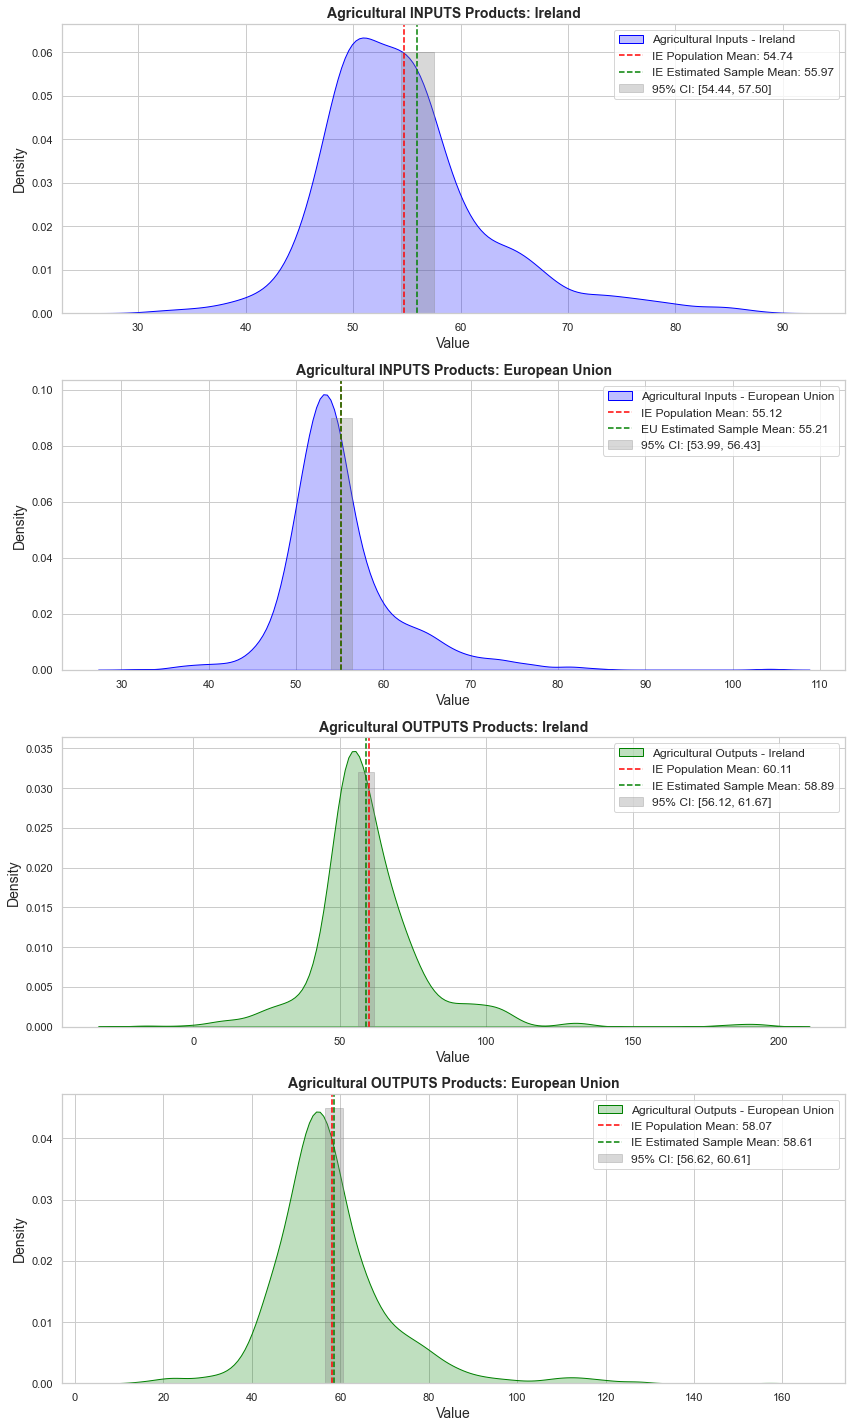

In [127]:
# Plotting the graphs side by side for mean of input and outputs: EU and IE
plt.figure(figsize=(12, 20))
sns.set_theme(style="whitegrid")

# KDE plot for 'Inputs Ireland'
plt.subplot(4, 1, 1)
kde_plot = sns.kdeplot(data=data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'inputs')], x='value', label='Agricultural Inputs - Ireland', color='blue', fill=True)
plt.axvline(inputs_IE_mean, color='red', linestyle='--', linewidth=1.5, label=f'IE Population Mean: {inputs_IE_mean:.2f}')
plt.axvline(mean_estimates_input_IE, color='green', linestyle='--', linewidth=1.5, label=f'IE Estimated Sample Mean: {mean_estimates_input_IE:.2f}')
# Add gray shadow to the confidence interval
plt.fill_betweenx(y=[0, 0.06], x1=confidence_interval_mean_input_IE[0], x2=confidence_interval_mean_input_IE[1], color='grey', 
                  alpha=0.3, label=f'95% CI: [{confidence_interval_mean_input_IE[0]:.2f}, {confidence_interval_mean_input_IE[1]:.2f}]')

plt.title('Agricultural INPUTS Products: Ireland', fontsize=14, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='', title_fontsize='13', fontsize='12')


# KDE plot for 'Inputs European Union'
plt.subplot(4, 1, 2)
kde_plot = sns.kdeplot(data=data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'inputs')], x='value', label='Agricultural Inputs - European Union', color='blue', fill=True)
plt.axvline(inputs_EU_mean, color='red', linestyle='--', linewidth=1.5, label=f'IE Population Mean: {inputs_EU_mean:.2f}')
plt.axvline(mean_estimates_input_EU, color='green', linestyle='--', linewidth=1.5, label=f'EU Estimated Sample Mean: {mean_estimates_input_EU:.2f}')
# Add gray shadow to the confidence interval
plt.fill_betweenx(y=[0, 0.09], x1=confidence_interval_mean_input_EU[0], x2=confidence_interval_mean_input_EU[1], color='grey', 
                  alpha=0.3, label=f'95% CI: [{confidence_interval_mean_input_EU[0]:.2f}, {confidence_interval_mean_input_EU[1]:.2f}]')

plt.title('Agricultural INPUTS Products: European Union', fontsize=14, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='', title_fontsize='13', fontsize='12')


# KDE plot for 'Outputs Ireland'
plt.subplot(4, 1, 3)
kde_plot = sns.kdeplot(data=data_IE_EU[(data_IE_EU['area'] == 'IE') & (data_IE_EU['type'] == 'outputs')], x='value', label='Agricultural Outputs - Ireland', color='green', fill=True)
plt.axvline(outputs_IE_mean, color='red', linestyle='--', linewidth=1.5, label=f'IE Population Mean: {outputs_IE_mean:.2f}')
plt.axvline(mean_estimates_output_IE, color='green', linestyle='--', linewidth=1.5, label=f'IE Estimated Sample Mean: {mean_estimates_output_IE:.2f}')
# Add gray shadow to the confidence interval
plt.fill_betweenx(y=[0, 0.032], x1=confidence_interval_mean_output_IE[0], x2=confidence_interval_mean_output_IE[1], color='grey', 
                  alpha=0.3, label=f'95% CI: [{confidence_interval_mean_output_IE[0]:.2f}, {confidence_interval_mean_output_IE[1]:.2f}]')

plt.title('Agricultural OUTPUTS Products: Ireland', fontsize=14, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='', title_fontsize='13', fontsize='12')



# KDE plot for 'Outputs European Union
plt.subplot(4, 1, 4)
kde_plot = sns.kdeplot(data=data_IE_EU[(data_IE_EU['area'] == 'EU') & (data_IE_EU['type'] == 'outputs')], x='value', label='Agricultural Outputs - European Union', color='green', fill=True)
plt.axvline(outputs_EU_mean, color='red', linestyle='--', linewidth=1.5, label=f'IE Population Mean: {outputs_EU_mean:.2f}')
plt.axvline(mean_estimates_output_EU, color='green', linestyle='--', linewidth=1.5, label=f'IE Estimated Sample Mean: {mean_estimates_output_EU:.2f}')
# Add gray shadow to the confidence interval
plt.fill_betweenx(y=[0, 0.045], x1=confidence_interval_mean_output_EU[0], x2=confidence_interval_mean_output_EU[1], color='grey', 
                  alpha=0.3, label=f'95% CI: [{confidence_interval_mean_output_EU[0]:.2f}, {confidence_interval_mean_output_EU[1]:.2f}]')

plt.title('Agricultural OUTPUTS Products: European Union', fontsize=14, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='', title_fontsize='13', fontsize='12')

plt.tight_layout()
plt.show()

## Statistical Tests - Parametric and Non-Parametric

The study of the tests will be carried out in two ways. Characteristics of Agricultural Inputs and Outputs Products will be studied among:

    - Ireland x European Union
    - Ireland x Countries with Similarities

### Shapiro-Wilk Test (Parametric Test)

Apply some tests that assume data with normal distribution, we will first check this assumption using the Shapiro-Wilk test.

- Comparison:  Agricultural Inputs and Outputs Products - Normal Distribution or not.

- Test Proposal: Check if the Agricultural Inputs and Outputs Products values are normally distributed.

- Hypotheses:
    - Null Hypothesis (H0): The data follows a normal distribution.
    - Alternative Hypothesis (H1): The data does not follow a normal distribution.

In [128]:
# Perform parametric test: Shapiro-Wilk
statistic, p_value = stats.shapiro(data_IE_EU['value'])

In [129]:
print(f"Shapiro-Wilk Test Statistic: {statistic}")
print(f"P-value: {p_value}")

Shapiro-Wilk Test Statistic: 0.8170347213745117
P-value: 0.0


In [130]:
if p_value > 0.05:
    print("The data follows a normal distribution (we do not reject H0).")
else:
    print("The data does not follow a normal distribution (we reject H0).")

The data does not follow a normal distribution (we reject H0).


- Applying the Log-Transformation

In [131]:
# Using log transformation to transform in a symmetric variable
data_IE_EU['log_value'] = np.log(data_IE_EU['value'])

In [132]:
data_IE_EU.isnull().sum()

type         0
year         0
quarter      0
product      0
class        0
value        0
area         0
log_value    2
dtype: int64

<AxesSubplot:xlabel='log_value', ylabel='Density'>

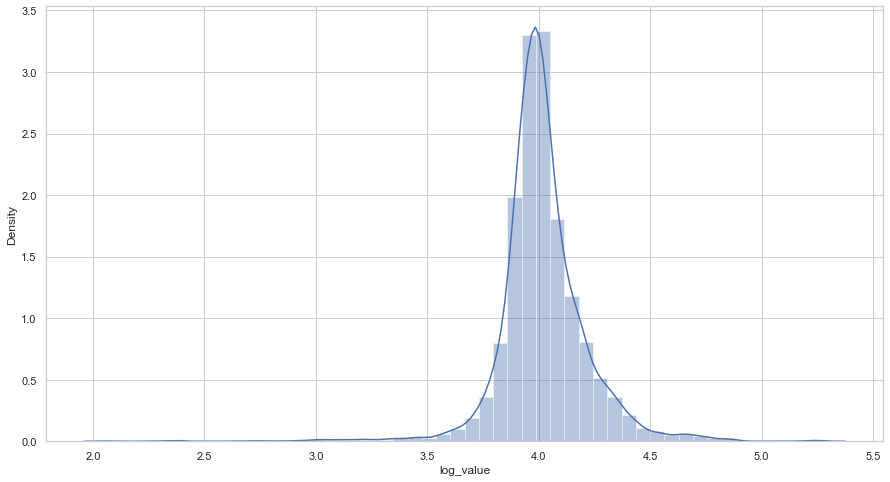

In [133]:
plt.figure(figsize=(15,8))
sns.distplot(data_IE_EU['log_value'])

- Applying the test again to check the data normality

In [134]:
# Perform parametric test: Shapiro-Wilk
statistic, p_value = stats.shapiro(data_IE_EU['log_value'])
print(f"Shapiro-Wilk Test Statistic with Log-transformation: {statistic}")
print(f"P-value with Log-transformation: {p_value}")

Shapiro-Wilk Test Statistic with Log-transformation: nan
P-value with Log-transformation: 1.0


In [135]:
if p_value > 0.05:
    print("The data follows a normal distribution (we do not reject H0).")
else:
    print("The data does not follow a normal distribution (we reject H0).")

The data follows a normal distribution (we do not reject H0).


### Independent Two-Sample t-Test (Parametric Test)

- Comparison: Agricultural Inputs and Outputs Products - Mean of Ireland x  Mean of European Union

- Test Proposal: Compare Ireland's Agricultural Inputs and Outputs Products averages with the average for European Union countries (excluding Ireland) and determine whether the averages differ significantly.


- Hypothesis:
    - Null Hypothesis (H0): There is no difference in the mean of Agriculture Inputs and Outputs Products between Ireland and European Union countries (without Ireland).
    - Alternative Hypothesis (H1): There is a difference in the mean between Ireland and European Union.

In [136]:
# Perform parametric test: Independent t-test

# Using the log-trasformation values with normal distribution
t_stat_IE_EU, p_val_IE_EU_t = stats.ttest_ind(data_IE_EU[(data_IE_EU['area'] == 'IE')]['log_value'].dropna(), data_IE_EU[(data_IE_EU['area'] == 'EU')]['log_value'].dropna())

In [137]:
# Print results
print("Comparison: Agricultural Inputs and Outputs Products - Mean of Ireland x  Mean of European Union")
print("Parametric t-test p-value:", p_val_IE_EU_t)

Comparison: Agricultural Inputs and Outputs Products - Mean of Ireland x  Mean of European Union
Parametric t-test p-value: 0.09878009481915333


In [138]:
if p_val_IE_EU_t < 0.05:
    print("Parametric t-test: Reject null hypothesis. There is a significant difference in the means between Ireland and European Union.")
else:
    print("Parametric t-test: Fail to reject null hypothesis. There is no significant difference in the means between Ireland and European Union.")

Parametric t-test: Fail to reject null hypothesis. There is no significant difference in the means between Ireland and European Union.


### Mann-Whitney U Test (Non-Parametric Test)

- Comparison: Agricultural Inputs and Outputs Products - Mean of Ireland x  Mean of European Union

- Test Proposal: Compare Ireland's Agricultural Inputs and Outputs Products averages with the average for European Union countries (excluding Ireland) and determine whether the averages differ significantly.

- Hypothesis:
    - Null Hypothesis (H0): There is no difference in the mean of Agriculture Inputs and Outputs Products between Ireland and European Union countries (without Ireland).
    - Alternative Hypothesis (H1): There is a difference in the mean between Ireland and European Union.

In [139]:
# Perform non-parametric test: Mann-Whitney U test
u_stat_IE_EU, p_val_gender_u_IE_EU = stats.mannwhitneyu(data_IE_EU[(data_IE_EU['area'] == 'IE')]['value'], data_IE_EU[(data_IE_EU['area'] == 'EU')]['value'])

In [140]:
print("Comparison: Agricultural Inputs and Outputs Products - Mean of Ireland x  Mean of European Union")
print("Non-parametric Mann-Whitney U test p-value:", p_val_gender_u_IE_EU)

Comparison: Agricultural Inputs and Outputs Products - Mean of Ireland x  Mean of European Union
Non-parametric Mann-Whitney U test p-value: 0.012400667208821284


In [141]:
if p_val_gender_u_IE_EU < 0.05:
    print("Non-parametric Mann-Whitney U test: Reject null hypothesis. There is a significant difference in the means between Ireland and European Union.")
else:
    print("Non-parametric Mann-Whitney U test: Fail to reject null hypothesis. There is no significant difference in the means between Ireland and European Union.")

Non-parametric Mann-Whitney U test: Reject null hypothesis. There is a significant difference in the means between Ireland and European Union.


### Checking the values by country

In [142]:
inputs_country_tests = input_output.groupby('country_code')['value'].sum().reset_index()   # Table of Agricultural Inputs
inputs_country_tests= inputs_country_tests.sort_values(by = 'value', ascending = False).reset_index()


(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.,
        700000., 800000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

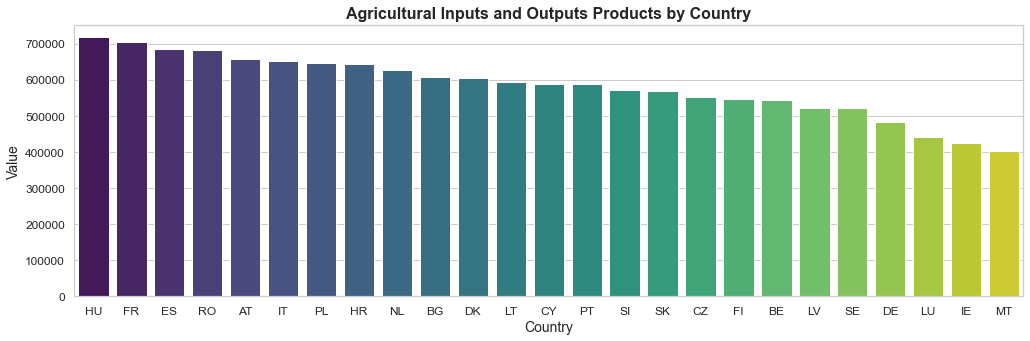

In [143]:
# Plotting the 'values' per country code 
plt.figure(figsize=(17,5))                                                      # size of the figure

sns.barplot(x = 'country_code', y = 'value', data = inputs_country_tests, palette='viridis')   # barplot graph
plt.title('Agricultural Inputs and Outputs Products by Country', fontsize=16, weight='bold')                        # title of the graph 
plt.xlabel('Country', fontsize=14)                                                 # title and size of the x label
plt.ylabel('Value', fontsize=14)                                                # title and size of the x label
plt.xticks(fontsize=12)                                                         # size of the x ticks
plt.yticks(fontsize=12)                                                         # size of the y ticks

The countries Malta (MT), Portugal (PT) and Luxembourg (LU) have Agricultural Inputs and Outputs Products total values similar to Ireland. We will use the following tests to find out if these similarities are really significant.

### One-Way ANOVA (Parametric Test)

- Comparison: Agricultural Inputs and Outputs Products - Means comparison between (Ireland x Malta x Portugal x Luxembourg)

- Test Proposal: Defiine if the Mean of Agricultural Inputs and Outputs Products for the countries Ireland (IE), Malta (MT), Portugal (PT) and Luxembourg (LU) has a significant difference or if the countries have the same behaviour.

- Hypotheses:
    - Null Hypothesis (H0): All group means are equal.
    - Alternative Hypothesis (H1): At least one group mean is different.

The ANOVA test assumes data normality. This way, we will use log-transformation to make our data Normally distributed and add a constant to avoid NA and Inf values.

In [144]:
# Perform non-parametric test: One-Way ANOVA
constant = 100
ANOVA_stat__IE_LU_PT_MT, ANOVA_p_value__IE_LU_PT_MT = stats.f_oneway(np.log(input_output[(input_output['country_code'] == 'IE')]['value']+constant), 
                                                                     np.log(input_output[(input_output['country_code'] == 'MT')]['value']+constant), 
                                                                     np.log(input_output[(input_output['country_code'] == 'PT')]['value']+constant), 
                                                                     np.log(input_output[(input_output['country_code'] == 'LU')]['value']+constant))

In [145]:
print("Comparison: Agricultural Inputs and Outputs Products - Means comparison between (Ireland x Malta x Portugal x Luxembourg)")
print("Parametric One-Way ANOVA p-value:", ANOVA_p_value__IE_LU_PT_MT)

Comparison: Agricultural Inputs and Outputs Products - Means comparison between (Ireland x Malta x Portugal x Luxembourg)
Parametric One-Way ANOVA p-value: 0.0005404903695815851


In [146]:
if ANOVA_p_value__IE_LU_PT_MT < 0.05:
    print("Parametric One-Way ANOVA: Reject null hypothesis. There is a significant difference between the means of the countries Ireland, Malta, Portugal and Luxembourg.")
else:
    print("Parametric One-Way ANOVA: Fail to reject null hypothesis. There is no significant difference between the means of the countries Ireland, Malta, Portugal and Luxembourg.")

Parametric One-Way ANOVA: Reject null hypothesis. There is a significant difference between the means of the countries Ireland, Malta, Portugal and Luxembourg.


### Kruskal-Wallis Test (Non-Parametric Test)

- Comparison: Agricultural Inputs and Outputs Products - Distributuion Population comparison between (Ireland x Malta x Portugal x Luxembourg)

- Test Proposal: Comparison of the medians of Agricultural Inputs and Outputs Products for the countries Ireland (IE), Malta (MT), Portugal (PT) and Luxembourg (LU).

- Hypotheses:
    - Null Hypothesis (H0): Population distributions are equal.
    - Alternative Hypothesis (H1): At least one of the population distributions is different.

In [147]:
# Perform non-parametric test: Kruskal-Wallis Test
kw_stat_IE_LU_PT_MT, p_value_IE_LU_PT_MT_kw = stats.kruskal(input_output[(input_output['country_code'] == 'IE')]['value'], 
                                                            input_output[(input_output['country_code'] == 'MT')]['value'], 
                                                            input_output[(input_output['country_code'] == 'PT')]['value'], 
                                                            input_output[(input_output['country_code'] == 'LU')]['value'])

In [148]:
print("Comparison: Agricultural Inputs and Outputs Products - Distributuion Population between (Ireland x Malta x Portugal x Luxembourg)")
print("Non-parametric Kruskal-Wallis Test p-value:", p_value_IE_LU_PT_MT_kw)

Comparison: Agricultural Inputs and Outputs Products - Distributuion Population between (Ireland x Malta x Portugal x Luxembourg)
Non-parametric Kruskal-Wallis Test p-value: 2.309473471900063e-16


In [149]:
if p_value_IE_LU_PT_MT_kw < 0.05:
      print("Non-parametric Kruskal-Wallis test: Reject the null hypothesis. There is a significant difference between the population distributions of the countries Ireland, Malta, Portugal and Luxembourg.")
else:
      print("Non-parametric Kruskal-Wallis test: Failed to reject the null hypothesis. There is no significant difference between the population distributions of the countries Ireland, Malta, Portugal and Luxembourg.")

Non-parametric Kruskal-Wallis test: Reject the null hypothesis. There is a significant difference between the population distributions of the countries Ireland, Malta, Portugal and Luxembourg.


# Reducing Memory Usage

- Deleting some vriables to clean the memory

In [150]:
del input_agri, input_agri_f, input_output_remv_outliers, inputs_country_tests, input_agri_transp, inputs_countrycode
import gc
gc.collect()

16339

# Feature Engineering

## Feature Engineering

### Transforming the Variables

- Agregating the Dataset per Country

In [190]:
input_output_agg_country = data_IE_EU.groupby(['area','year','quarter','class']).agg({'value': ['sum']}).reset_index()
input_output_agg_country

,area,year,quarter,class,value
,,,,,sum
0,EU,2011,1,ANIMAL PRODUCTS,338.864583
1,EU,2011,1,ANIMALS,591.990431
2,EU,2011,1,CEREALS,1347.443144
3,EU,2011,1,FORAGE PLANTS,196.145536
4,EU,2011,1,FRUIT,487.339694
...,...,...,...,...,...
1367,IE,2017,4,OTHER GOODS AND SERVICES,56.175000
1368,IE,2017,4,PLANT PROTECTION PRODUCTS AND PESTICIDES,246.525000
1369,IE,2017,4,SEEDS AND PLANTING STOCK,56.625000


In [191]:
input_output_agg_country.columns = [''.join(col).strip() for col in input_output_agg_country.columns.values]

In [192]:
input_output_agg_country

,area,year,quarter,class,valuesum
0,EU,2011,1,ANIMAL PRODUCTS,338.864583
1,EU,2011,1,ANIMALS,591.990431
2,EU,2011,1,CEREALS,1347.443144
3,EU,2011,1,FORAGE PLANTS,196.145536
4,EU,2011,1,FRUIT,487.339694
...,...,...,...,...,...
1367,IE,2017,4,OTHER GOODS AND SERVICES,56.175000
1368,IE,2017,4,PLANT PROTECTION PRODUCTS AND PESTICIDES,246.525000
1369,IE,2017,4,SEEDS AND PLANTING STOCK,56.625000
1370,IE,2017,4,TRANSPORT EQUIPMENT,148.650000


### Feature Encoding 

In [193]:
# Transforming variables in dummies
input_output_ML = pd.get_dummies(input_output_agg_country, columns=['class','quarter'], drop_first=True)

In [194]:
label_encoder = LabelEncoder()
input_output_ML['area'] = label_encoder.fit_transform(input_output_ML['area'])

In [195]:
input_output_ML

,area,year,valuesum,class_ANIMAL PRODUCTS,class_ANIMALS,class_BUILDINGS,class_CEREALS,class_ENERGY,class_FARM BUILDINGS (NON-RESIDENTIAL),class_FERTILISERS AND SOIL IMPROVERS,...,class_VEGETABLES AND HORTICULTURAL PRODUCTS,class_VETERINARY EXPENSES,class_WINE,quarter_1,quarter_2,quarter_2,quarter_3,quarter_3,quarter_4,quarter_4
0,0,2011,338.864583,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2011,591.990431,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2011,1347.443144,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2011,196.145536,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2011,487.339694,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,1,2017,56.175000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1368,1,2017,246.525000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1369,1,2017,56.625000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1370,1,2017,148.650000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Splitting in Train and Test

In [196]:
X = input_output_ML.drop(['area'], axis=1)
y = input_output_ML['area']

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Normalizing the Dataset

In [198]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Machine Learning

## Sentimental Analysis

- Proposal: 
    - Analyze posts and comments about Agriculture in general using the social network Reddit.

### Setting up the Environment Variables

In [160]:
user_agent = os.getenv('REDDIT_user_agent')
client_id = os.getenv('REDDIT_client_id')
client_secret = os.getenv('REDDIT_client_secret')

### Connecting with Reddit

In [161]:
# Connecting and Testing
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

# Testing the collection of comments about Agriculture
headlines = set()
try:
    for submission in reddit.subreddit('agriculture').hot(limit=None):
        print(submission.title)
        print(submission.id)
        print(submission.author)
        print(submission.created_utc)
        print(submission.score)
        print(submission.upvote_ratio)
        print(submission.url)
        break
        headlines.add(submission.title)
    print(len(headlines))
except praw.exceptions.APIException as e:
    print(f"Erro na API: {e}")
except Exception as e:
    print(f"Outro erro ocorreu: {e}")


Rice Farm!!
1d4rcne
patriciaytm
1717146892.0
6
0.88
https://i.redd.it/90cbuao7bq3d1.jpeg
0


In [162]:
# Collecting comments and posts about Agriculture
headlines = set()
try:
    for submission in reddit.subreddit('agriculture').hot(limit=None):
        headlines.add(submission.title)
    print(len(headlines))
except praw.exceptions.APIException as e:
    print(f"Erro na API: {e}")
except Exception as e:
    print(f"Outro erro ocorreu: {e}")


886


In [163]:
# Saving the data in a dataframe
reddit_agriculture = pd.DataFrame(headlines)
reddit_agriculture

,0
0,something wrong with my lemon tree?
1,USDA Overpayment of Relief Funds
2,Does Russia produce and export ginger root?
3,Cono weeder
4,Precision Agriculture Sub
...,...
881,Do you use subsoilers?
882,"Russian Government Seized AgroTerra’s Assets, ..."
883,White collar guy what to farm what he can do?
884,Fungicide Exposure


In [164]:
# Saving the dataset in a csv file
reddit_agriculture.to_csv('agriculture_sentimental_analysis.csv',header = False, encoding = 'utf-8', index = False)

### Applying the Sentimental Analysis

In [165]:
sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

results[:3]

[{'neg': 0.383,
  'neu': 0.617,
  'pos': 0.0,
  'compound': -0.4767,
  'headline': 'something wrong with my lemon tree?'},
 {'neg': 0.0,
  'neu': 0.563,
  'pos': 0.437,
  'compound': 0.4767,
  'headline': 'USDA Overpayment of Relief Funds'},
 {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0,
  'headline': 'Does Russia produce and export ginger root?'}]

In [166]:
reddit_agriculture = pd.DataFrame.from_records(results)

In [167]:
# Reclassifying the scores
reddit_agriculture['class'] = 0
reddit_agriculture.loc[reddit_agriculture['compound'] > 0.2, 'class'] = 1
reddit_agriculture.loc[reddit_agriculture['compound'] < -0.2, 'class'] = -1
reddit_agriculture

,neg,neu,pos,compound,headline,class
0,0.383,0.617,0.000,-0.4767,something wrong with my lemon tree?,-1
1,0.000,0.563,0.437,0.4767,USDA Overpayment of Relief Funds,1
2,0.000,1.000,0.000,0.0000,Does Russia produce and export ginger root?,0
3,0.000,1.000,0.000,0.0000,Cono weeder,0
4,0.000,1.000,0.000,0.0000,Precision Agriculture Sub,0
...,...,...,...,...,...,...
881,0.000,1.000,0.000,0.0000,Do you use subsoilers?,0
882,0.000,0.805,0.195,0.1779,"Russian Government Seized AgroTerra’s Assets, ...",0
883,0.000,1.000,0.000,0.0000,White collar guy what to farm what he can do?,0
884,0.000,1.000,0.000,0.0000,Fungicide Exposure,0


In [168]:
reddit_agriculture = reddit_agriculture[['headline','class']]

### Checking the Sentimental Analysis Results

In [169]:
# Counting thee Scores
reddit_agriculture['class'].value_counts()

 0    599
 1    213
-1     74
Name: class, dtype: int64

In [170]:
# Checking the proportion of scores
reddit_agriculture['class'].value_counts(normalize = True) * 100

 0    67.607223
 1    24.040632
-1     8.352144
Name: class, dtype: float64

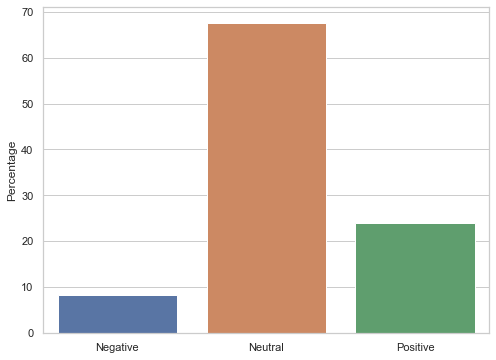

In [171]:
# Plotting the scores

fig, ax = plt.subplots(figsize = (8,6))

counts = reddit_agriculture['class'].value_counts(normalize = True) * 100

sns.barplot(x = counts.index, y = counts , ax = ax)

ax.set_xticklabels(['Negative','Neutral','Positive'])
ax.set_ylabel('Percentage')

plt.show()

## Random Forest

### Defining the Model

In [241]:
rf = RandomForestClassifier(random_state=42)

### Defining the Hyperparameters

In [242]:
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

### Training the Model Using GridSearchCV

In [243]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [244]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

### Best Hyperparameters

In [245]:
best_params = grid_search.best_params_
print(f'Best hyperparameters: {best_params}')

Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


### Predictions with the Best Model (Using the Best Hyperparameters)

In [246]:
best_rf = grid_search.best_estimator_
predictions = best_rf.predict(X_test)

### Performance of the Model

In [247]:
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.8072727272727273
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.83       159
           1       0.74      0.83      0.78       116

    accuracy                           0.81       275
   macro avg       0.80      0.81      0.80       275
weighted avg       0.81      0.81      0.81       275



### Confusion Matrix

In [248]:
confusion_matrix(y_test, predictions, labels=best_rf.classes_)

array([[126,  33],
       [ 20,  96]], dtype=int64)

### Cross Validation

In [250]:
# Cross-validation
best_rf = grid_search.best_estimator_
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5)

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {cv_scores.mean()}')

Cross-Validation Scores: [0.77272727 0.83181818 0.78995434 0.76255708 0.83105023]
Mean CV Score: 0.7976214196762141


## Support Vector Machine (SVM)

In [229]:
svm = SVC()

### Defining the Hyperparameters

In [233]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}


### Training the Model Using GridSearchCV

In [234]:
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [235]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

### Best Hyperparameters

In [236]:
best_params = grid_search.best_params_
print(f'Best hyperparameters: {best_params}')

Best hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}


### Predictions with the Best Model (Using the Best Hyperparameters)

In [237]:
best_svm = grid_search.best_estimator_
predictions = best_svm.predict(X_test)

### Performance of the Model

In [238]:
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.7090909090909091
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       159
           1       0.63      0.75      0.69       116

    accuracy                           0.71       275
   macro avg       0.71      0.71      0.71       275
weighted avg       0.72      0.71      0.71       275



### Confusion Matrix

In [239]:
confusion_matrix(y_test, predictions, labels=best_rf.classes_)

array([[108,  51],
       [ 29,  87]], dtype=int64)

### Cross Validation

In [240]:
# Cross-validation
best_svm = grid_search.best_estimator_
cv_scores = cross_val_score(best_svm, X_train, y_train, cv=5)

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {cv_scores.mean()}')

Cross-Validation Scores: [0.70909091 0.72272727 0.70776256 0.69863014 0.70319635]
Mean CV Score: 0.7082814445828144
